# Análisis de Víctimas en carpetas de investigación FGJ

Objetivo:
* Implementar un modelo del clasificación para el análsis de las víctimas en carpetas de investigación FGJ en la Ciudad de México
* Datos: https://datos.cdmx.gob.mx/dataset/victimas-en-carpetas-de-investigacion-fgj

## Bibliotecas y setup

In [4]:
# Dependencies
import zipfile
import io
import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.mlab as mlab
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#
import warnings
warnings.filterwarnings('ignore') # Para ignorar warnings

### Nota: Si alguna biblioteca no se instala utilizar el siguiente código

In [ ]:
#
#!pip install pip # Cuando utilicen por primera vez pip
#!pip install <<name_library>>

## SECCIÓN I:

### ¿Qué nos dicen los datos?

Se trata de datos que contienen la información actualizada de las víctimas de los delitos en las carpetas de investigación de la Fiscalía General de Justicia (FGJ) de la Ciudad de México a partir de enero de 2019.

Para una correcta interpretación de la información, la CDMX hizó las siguientes aclaraciones:

* El campo "fecha_hecho" representa la fecha en la que ocurrió el hecho.
* El campo "fecha_inicio" corresponde a la fecha de la apertura de la carpeta de investigación.
* En esta base se señala el sexo de la víctima, así como la fecha en que ocurrieron los hechos denunciados.
* Es importante destacar que, aunque en algunas ocasiones la víctima es la persona denunciante, en otras, denunciante y víctima son personas diferentes (por ejemplo, casos en los que menores de edad son víctimas).
* Es posible que en una misma denuncia se incluya a una o más víctimas.
* Existen otras aclaraciones en: https://datos.cdmx.gob.mx/dataset/victimas-en-carpetas-de-investigacion-fgj

**Los datos de esta tabla fueron actualizados por la FGJ el 29 de julio de 2020.**

Los datos antes de la actualización del 29 de julio de 2020 los puedes consultar en esta liga: Victimas antes de la actualización de julio de 2020 [https://archivo.datos.cdmx.gob.mx/fiscalia-general-de-justicia/victimas-en-carpetas-de-investigacion-fgj/victimas_ss_junio2020.csv]

In [130]:
# Consulta a una dirección Web que aloja un archivo CSV (DATOS ACTUALIZADOS)

# Opción 1
#Datos = pd.read_csv('https://archivo.datos.cdmx.gob.mx/FGJ/victimas/victimasFGJ_acumulado_2024_09.csv')

# Opción 2 (derivado del sello de la casa)
zip_file_name = 'victimasFGJ_acumulado_2024_09.csv.zip'
csv_file_name = 'victimasFGJ_acumulado_2024_09.csv'
with zipfile.ZipFile(zip_file_name, 'r') as zf:
    with zf.open(csv_file_name) as csv_file:
        Datos = pd.read_csv(io.TextIOWrapper(csv_file, 'utf-8'))

Datos.head()

,anio_inicio,mes_inicio,fecha_inicio,hora_inicio,anio_hecho,mes_hecho,fecha_hecho,hora_hecho,delito,categoria_delito,sexo,edad,tipo_persona,calidad_juridica,competencia,colonia_hecho,colonia_catalogo,alcaldia_hecho,alcaldia_catalogo,municipio_hecho,latitud,longitud
0,2019.0,Enero,2019-01-04,12:19:00,2018.0,Agosto,2018-08-29,12:00:00,FRAUDE,DELITO DE BAJO IMPACTO,Masculino,62.0,FISICA,OFENDIDO,FUERO COMUN,GUADALUPE INN,Guadalupe Inn,ALVARO OBREGON,Álvaro Obregón,CDMX,19.36125,-99.18314
1,2019.0,Enero,2019-01-04,12:20:00,2018.0,Diciembre,2018-12-15,15:00:00,"PRODUCCIÓN, IMPRESIÓN, ENAJENACIÓN, DISTRIBUCI...",DELITO DE BAJO IMPACTO,Femenino,38.0,FISICA,VICTIMA Y DENUNCIANTE,FUERO COMUN,VICTORIA DE LAS DEMOCRACIAS,Victoria De Las Democracias,AZCAPOTZALCO,Azcapotzalco,CDMX,19.47181,-99.16458
2,2019.0,Enero,2019-01-04,12:23:00,2018.0,Diciembre,2018-12-22,15:30:00,ROBO A TRANSEUNTE SALIENDO DEL BANCO CON VIOLE...,ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON ...,Masculino,42.0,FISICA,VICTIMA Y DENUNCIANTE,FUERO COMUN,COPILCO UNIVERSIDAD ISSSTE,Copilco El Bajo,COYOACAN,Coyoacán,CDMX,19.33797,-99.18611
3,2019.0,Enero,2019-01-04,12:27:00,2019.0,Enero,2019-01-04,06:00:00,ROBO DE VEHICULO DE SERVICIO PARTICULAR SIN VI...,ROBO DE VEHÍCULO CON Y SIN VIOLENCIA,Masculino,35.0,FISICA,VICTIMA Y DENUNCIANTE,FUERO COMUN,AGRÍCOLA PANTITLAN,Agricola Pantitlan,IZTACALCO,Iztacalco,CDMX,19.40327,-99.05983
4,2019.0,Enero,2019-01-04,12:35:00,2019.0,Enero,2019-01-03,20:00:00,ROBO DE MOTOCICLETA SIN VIOLENCIA,ROBO DE VEHÍCULO CON Y SIN VIOLENCIA,Masculino,NaN,FISICA,VICTIMA,FUERO COMUN,PROGRESISTA,Progresista,IZTAPALAPA,Iztapalapa,CDMX,19.35480,-99.06324


In [7]:
#

Datos.shape

(1415763, 22)

In [8]:
#

Datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1415763 entries, 0 to 1415762
Data columns (total 22 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   anio_inicio        1415748 non-null  float64
 1   mes_inicio         1415748 non-null  object 
 2   fecha_inicio       1415748 non-null  object 
 3   hora_inicio        1415748 non-null  object 
 4   anio_hecho         1415343 non-null  float64
 5   mes_hecho          1415343 non-null  object 
 6   fecha_hecho        1415342 non-null  object 
 7   hora_hecho         1415353 non-null  object 
 8   delito             1415749 non-null  object 
 9   categoria_delito   1415749 non-null  object 
 10  sexo               1168059 non-null  object 
 11  edad               931053 non-null   float64
 12  tipo_persona       1408196 non-null  object 
 13  calidad_juridica   1415748 non-null  object 
 14  competencia        1415749 non-null  object 
 15  colonia_hecho      1340796 non-n

In [11]:
# Consulta a una dirección Web que aloja un archivo CSV (DATOS NO ACTUALIZADOS)

# Opción 1
#Datos_OLD = pd.read_csv('https://archivo.datos.cdmx.gob.mx/fiscalia-general-de-justicia/victimas-en-carpetas-de-investigacion-fgj/victimas_ss_junio2020.csv')

# Opción 2 (derivado del sello de la casa)
zip_file_name = 'victimas_ss_junio2020.csv.zip'
csv_file_name = 'victimas_ss_junio2020.csv'
with zipfile.ZipFile(zip_file_name, 'r') as zf:
    with zf.open(csv_file_name) as csv_file:
        Datos_OLD = pd.read_csv(io.TextIOWrapper(csv_file, 'utf-8'))

Datos_OLD.tail()

,idCarpeta,Año_inicio,Mes_inicio,FechaInicio,Delito,Categoria,Sexo,Edad,TipoPersona,CalidadJuridica,competencia,Año_hecho,Mes_hecho,FechaHecho,HoraHecho,HoraInicio,AlcaldiaHechos,ColoniaHechos,Calle_hechos,Calle_hechos2,latitud,longitud
369734,8711995,2020,Junio,30/06/2020,FRAUDE,DELITO DE BAJO IMPACTO,Femenino,56.0,FISICA,VICTIMA Y DENUNCIANTE,FUERO COMUN,2020.0,Junio,29/06/2020,03:30:00,23:39:00,ALVARO OBREGON,AXOTLA,AV UNIVERSIDAD,INDUSTRIA,19.358334,-99.172309
369735,8711983,2020,Junio,30/06/2020,NEGACION DEL SERVICIO PUBLICO,DELITO DE BAJO IMPACTO,Masculino,NaN,FISICA,VICTIMA Y DENUNCIANTE,FUERO COMUN,2019.0,Diciembre,20/12/2019,22:30:00,23:46:00,ALVARO OBREGON,PROGRESO,AV- MEMXICO,AV. TOLUCA Y TLAXCALA (FISCALIA DE INVESTIGACI...,19.339645,-99.201685
369736,8711983,2020,Junio,30/06/2020,NEGACION DEL SERVICIO PUBLICO,DELITO DE BAJO IMPACTO,Femenino,NaN,FISICA,VICTIMA Y DENUNCIANTE,FUERO COMUN,2019.0,Diciembre,20/12/2019,22:30:00,23:46:00,ALVARO OBREGON,PROGRESO,AV- MEMXICO,AV. TOLUCA Y TLAXCALA (FISCALIA DE INVESTIGACI...,19.339645,-99.201685
369737,8711980,2020,Junio,30/06/2020,AMENAZAS,DELITO DE BAJO IMPACTO,Femenino,NaN,FISICA,VICTIMA Y DENUNCIANTE,FUERO COMUN,2020.0,Junio,30/06/2020,18:40:00,23:47:00,CUAUHTEMOC,GUERRERO,PEDRO MORENO,AV. PASEO DE LA REFORMA,19.441199,-99.143585
369738,8711986,2020,Junio,30/06/2020,VIOLENCIA FAMILIAR,DELITO DE BAJO IMPACTO,Femenino,28.0,FISICA,VICTIMA Y DENUNCIANTE,FUERO COMUN,2020.0,Junio,30/06/2020,21:30:00,23:55:00,IZTACALCO,SANTIAGO SUR,PLAYA NIZUC,AV. AMACUZAC,19.389455,-99.127101


In [12]:
#

Datos_OLD.shape

(369739, 22)

In [13]:
#

Datos_OLD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369739 entries, 0 to 369738
Data columns (total 22 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   idCarpeta        369739 non-null  int64  
 1   Año_inicio       369739 non-null  int64  
 2   Mes_inicio       369739 non-null  object 
 3   FechaInicio      369739 non-null  object 
 4   Delito           369739 non-null  object 
 5   Categoria        369739 non-null  object 
 6   Sexo             291714 non-null  object 
 7   Edad             231640 non-null  float64
 8   TipoPersona      366355 non-null  object 
 9   CalidadJuridica  369739 non-null  object 
 10  competencia      369739 non-null  object 
 11  Año_hecho        369492 non-null  float64
 12  Mes_hecho        369492 non-null  object 
 13  FechaHecho       369492 non-null  object 
 14  HoraHecho        369494 non-null  object 
 15  HoraInicio       369738 non-null  object 
 16  AlcaldiaHechos   369724 non-null  obje

In [14]:
# Agrupamos por año-mes y categoria_delito de los DATOS ACTUALIZADOS

Datos['Periodo'] = Datos['fecha_hecho'].str[:7]

Time_Serie = Datos[ ['Periodo', 'categoria_delito',
                     'anio_inicio'] ].groupby(by = ['Periodo',
                                                    'categoria_delito']).count().reset_index( drop = False)

Time_Serie = Time_Serie[ Time_Serie['Periodo'] >= '2019-01' \
                       ].reset_index( drop = True ).rename( columns = {'categoria_delito': 'Categoria',
                                                                       'anio_inicio' : 'Numero'} )

Time_Serie

,Periodo,Categoria,Numero
0,2019-01,DELITO DE BAJO IMPACTO,16562
1,2019-01,HECHO NO DELICTIVO,313
2,2019-01,HOMICIDIO DOLOSO,172
3,2019-01,LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO,161
4,2019-01,ROBO A CASA HABITACIÓN CON VIOLENCIA,60
...,...,...,...
1077,2024-09,ROBO A REPARTIDOR CON Y SIN VIOLENCIA,64
1078,2024-09,ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIO...,699
1079,2024-09,ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA,2
1080,2024-09,ROBO DE VEHÍCULO CON Y SIN VIOLENCIA,595


In [15]:
#

Time_Serie = pd.pivot_table( Time_Serie, values = 'Numero', index = ['Periodo'],
                             columns = ['Categoria'], aggfunc = 'sum' ).reset_index( drop = False )

Time_Serie

Categoria,Periodo,DELITO DE BAJO IMPACTO,HECHO NO DELICTIVO,HOMICIDIO DOLOSO,LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO,ROBO A CASA HABITACIÓN CON VIOLENCIA,ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA,ROBO A NEGOCIO CON VIOLENCIA,ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA,ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA,ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA,ROBO A REPARTIDOR CON Y SIN VIOLENCIA,ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA,ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA,ROBO DE VEHÍCULO CON Y SIN VIOLENCIA,SECUESTRO,VIOLACIÓN
0,2019-01,16562.0,313.0,172.0,161.0,60.0,52.0,1713.0,159.0,39.0,343.0,392.0,1309.0,10.0,1285.0,17.0,131.0
1,2019-02,15749.0,356.0,152.0,170.0,81.0,53.0,1308.0,133.0,49.0,424.0,312.0,1796.0,12.0,1163.0,2.0,121.0
2,2019-03,17738.0,279.0,191.0,171.0,69.0,63.0,1317.0,128.0,40.0,389.0,357.0,1799.0,13.0,1237.0,8.0,136.0
3,2019-04,16562.0,301.0,157.0,174.0,66.0,56.0,1256.0,105.0,25.0,375.0,313.0,1638.0,13.0,1275.0,1.0,154.0
4,2019-05,18217.0,327.0,213.0,166.0,69.0,66.0,1158.0,126.0,34.0,382.0,328.0,1552.0,16.0,1302.0,8.0,141.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,2024-05,18002.0,509.0,123.0,98.0,22.0,15.0,153.0,41.0,7.0,127.0,66.0,635.0,2.0,647.0,4.0,209.0
65,2024-06,16379.0,449.0,111.0,95.0,25.0,10.0,159.0,32.0,9.0,81.0,82.0,675.0,7.0,630.0,NaN,178.0
66,2024-07,15219.0,455.0,115.0,71.0,38.0,14.0,160.0,46.0,21.0,89.0,69.0,719.0,1.0,652.0,NaN,139.0
67,2024-08,14847.0,570.0,109.0,100.0,24.0,11.0,166.0,48.0,16.0,117.0,80.0,862.0,2.0,643.0,NaN,172.0


In [16]:
# Agrupamos por año-mes y categoria_delito de los DATOS NO ACTUALIZADOS

Datos_OLD['Periodo'] = Datos_OLD['FechaHecho'].str[6:10] + '-' + Datos_OLD['FechaHecho'].str[3:5]

Time_Serie_OLD = Datos_OLD[ ['Periodo', 'Categoria',
                             'idCarpeta'] ].groupby(by = ['Periodo',
                                                          'Categoria']).count().reset_index( drop = False)

Time_Serie_OLD = Time_Serie_OLD[ Time_Serie_OLD['Periodo'] >= '2019-01'\
                               ].reset_index( drop = True ).rename( columns = {'idCarpeta' : 'Numero'} )

Time_Serie_OLD

,Periodo,Categoria,Numero
0,2019-01,DELITO DE BAJO IMPACTO,16053
1,2019-01,HECHO NO DELICTIVO,306
2,2019-01,HOMICIDIO DOLOSO,172
3,2019-01,LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO,161
4,2019-01,ROBO A CASA HABITACIÓN CON VIOLENCIA,60
...,...,...,...
282,2020-06,ROBO A REPARTIDOR CON Y SIN VIOLENCIA,131
283,2020-06,ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIO...,596
284,2020-06,ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA,11
285,2020-06,ROBO DE VEHÍCULO CON Y SIN VIOLENCIA,750


In [17]:
#

Time_Serie_OLD = pd.pivot_table( Time_Serie_OLD, values = 'Numero', index = ['Periodo'],
                                 columns = ['Categoria'], aggfunc = 'sum' ).reset_index( drop = False )

Time_Serie_OLD

Categoria,Periodo,DELITO DE BAJO IMPACTO,HECHO NO DELICTIVO,HOMICIDIO DOLOSO,LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO,ROBO A CASA HABITACIÓN CON VIOLENCIA,ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA,ROBO A NEGOCIO CON VIOLENCIA,ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA,ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA,ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA,ROBO A REPARTIDOR CON Y SIN VIOLENCIA,ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA,ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA,ROBO DE VEHÍCULO CON Y SIN VIOLENCIA,SECUESTRO,VIOLACIÓN
0,2019-01,16053.0,306.0,172.0,161.0,60.0,52.0,1713.0,159.0,39.0,343.0,392.0,1309.0,10.0,1284.0,17.0,91.0
1,2019-02,15403.0,353.0,152.0,170.0,81.0,53.0,1308.0,132.0,49.0,424.0,312.0,1795.0,12.0,1161.0,2.0,104.0
2,2019-03,17370.0,275.0,191.0,171.0,69.0,63.0,1317.0,128.0,39.0,387.0,357.0,1799.0,13.0,1235.0,8.0,124.0
3,2019-04,16161.0,297.0,157.0,174.0,66.0,56.0,1255.0,105.0,25.0,375.0,313.0,1636.0,13.0,1274.0,1.0,139.0
4,2019-05,17785.0,321.0,213.0,166.0,69.0,66.0,1158.0,126.0,34.0,382.0,327.0,1550.0,16.0,1302.0,8.0,124.0
5,2019-06,16744.0,254.0,155.0,128.0,60.0,62.0,1093.0,125.0,25.0,272.0,282.0,1363.0,10.0,1184.0,8.0,109.0
6,2019-07,16523.0,252.0,161.0,126.0,74.0,74.0,1394.0,89.0,34.0,222.0,275.0,1241.0,10.0,1139.0,8.0,118.0
7,2019-08,17451.0,294.0,120.0,136.0,65.0,72.0,1144.0,100.0,38.0,166.0,363.0,1394.0,9.0,1103.0,4.0,128.0
8,2019-09,16325.0,291.0,147.0,150.0,60.0,57.0,1032.0,91.0,30.0,169.0,373.0,1242.0,13.0,1096.0,3.0,139.0
9,2019-10,14823.0,302.0,136.0,140.0,65.0,52.0,452.0,82.0,38.0,168.0,406.0,1157.0,16.0,978.0,6.0,155.0


In [18]:
#

Time_Serie = Time_Serie.drop('HECHO NO DELICTIVO', axis=1)
Time_Serie = Time_Serie.drop('SECUESTRO', axis=1)
Time_Serie = Time_Serie.drop('HOMICIDIO DOLOSO', axis=1)
Time_Serie = Time_Serie.drop('VIOLACIÓN', axis=1)
Time_Serie = Time_Serie.drop('LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO', axis=1)
Time_Serie = Time_Serie.drop('ROBO A CASA HABITACIÓN CON VIOLENCIA', axis=1)
Time_Serie = Time_Serie.drop('ROBO A NEGOCIO CON VIOLENCIA', axis=1)
Time_Serie = Time_Serie.drop('ROBO A REPARTIDOR CON Y SIN VIOLENCIA', axis=1)

In [19]:
#
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

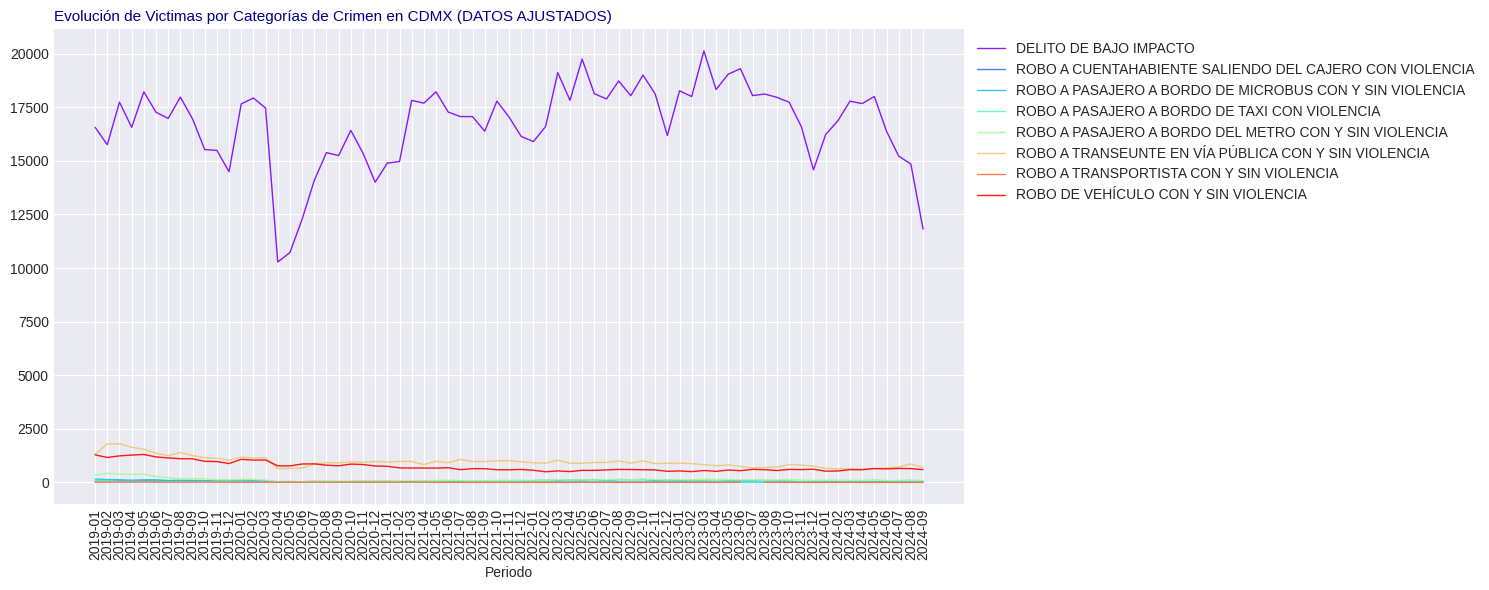

In [20]:
# Visualización

plt.style.use('seaborn-v0_8-darkgrid') # 'ggplot', 'seaborn-v0_8-darkgrid'

plt.figure( figsize = ( 15, 6 ) )

colors = cm.rainbow(np.linspace(0, 1, len(Time_Serie.columns) - 1))

# Plot multiple lines
for num, column in enumerate(Time_Serie.drop('Periodo', axis=1)):
    plt.plot(Time_Serie['Periodo'], Time_Serie[column],
             marker='', color=colors[num], linewidth=1,
             alpha=0.9, label=column)

# Add legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

# Add titles
plt.title( 'Evolución de Victimas por Categorías de Crimen en CDMX (DATOS AJUSTADOS)',
           loc = 'left', fontsize = 11, fontweight = 0, color = 'darkblue' )
plt.xlabel( 'Periodo' )
plt.ylabel( '' )

plt.xticks( rotation = 90 )

# Adjust layout to make room for the legend
plt.tight_layout()

In [21]:
#

Time_Serie = Time_Serie.drop('DELITO DE BAJO IMPACTO', axis=1)

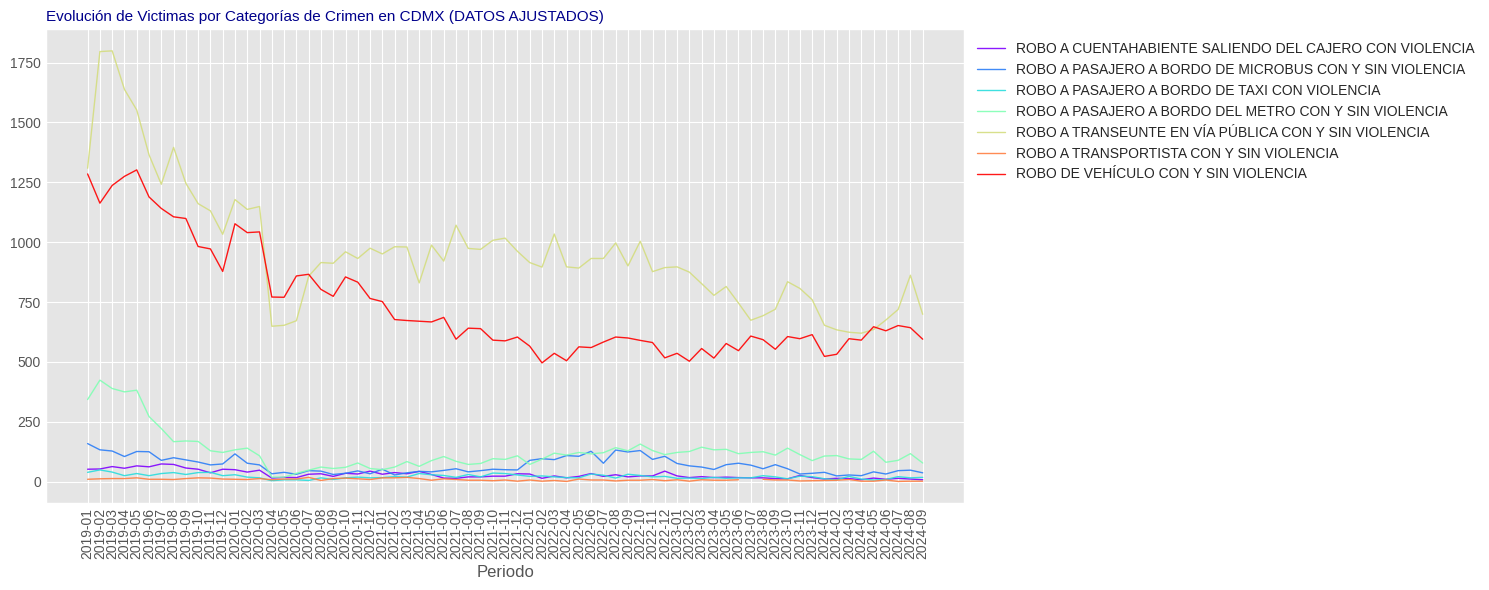

In [22]:
# Visualización

plt.style.use('ggplot') # 'ggplot', 'seaborn-v0_8-darkgrid'

plt.figure( figsize = ( 15, 6 ) )

colors = cm.rainbow(np.linspace(0, 1, len(Time_Serie.columns) - 1))

# Plot multiple lines
for num, column in enumerate(Time_Serie.drop('Periodo', axis=1)):
    plt.plot(Time_Serie['Periodo'], Time_Serie[column],
             marker='', color=colors[num], linewidth=1,
             alpha=0.9, label=column)

# Add legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

# Add titles
plt.title( 'Evolución de Victimas por Categorías de Crimen en CDMX (DATOS AJUSTADOS)',
           loc = 'left', fontsize = 11, fontweight = 0, color = 'darkblue' )
plt.xlabel( 'Periodo' )
plt.ylabel( '' )

plt.xticks( rotation = 90 )

# Adjust layout to make room for the legend
plt.tight_layout()

In [23]:
#

Time_Serie_OLD = Time_Serie_OLD.drop('HECHO NO DELICTIVO', axis=1)
Time_Serie_OLD = Time_Serie_OLD.drop('SECUESTRO', axis=1)
Time_Serie_OLD = Time_Serie_OLD.drop('HOMICIDIO DOLOSO', axis=1)
Time_Serie_OLD = Time_Serie_OLD.drop('VIOLACIÓN', axis=1)
Time_Serie_OLD = Time_Serie_OLD.drop('LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO', axis=1)
Time_Serie_OLD = Time_Serie_OLD.drop('ROBO A CASA HABITACIÓN CON VIOLENCIA', axis=1)
Time_Serie_OLD = Time_Serie_OLD.drop('ROBO A NEGOCIO CON VIOLENCIA', axis=1)
Time_Serie_OLD = Time_Serie_OLD.drop('ROBO A REPARTIDOR CON Y SIN VIOLENCIA', axis=1)

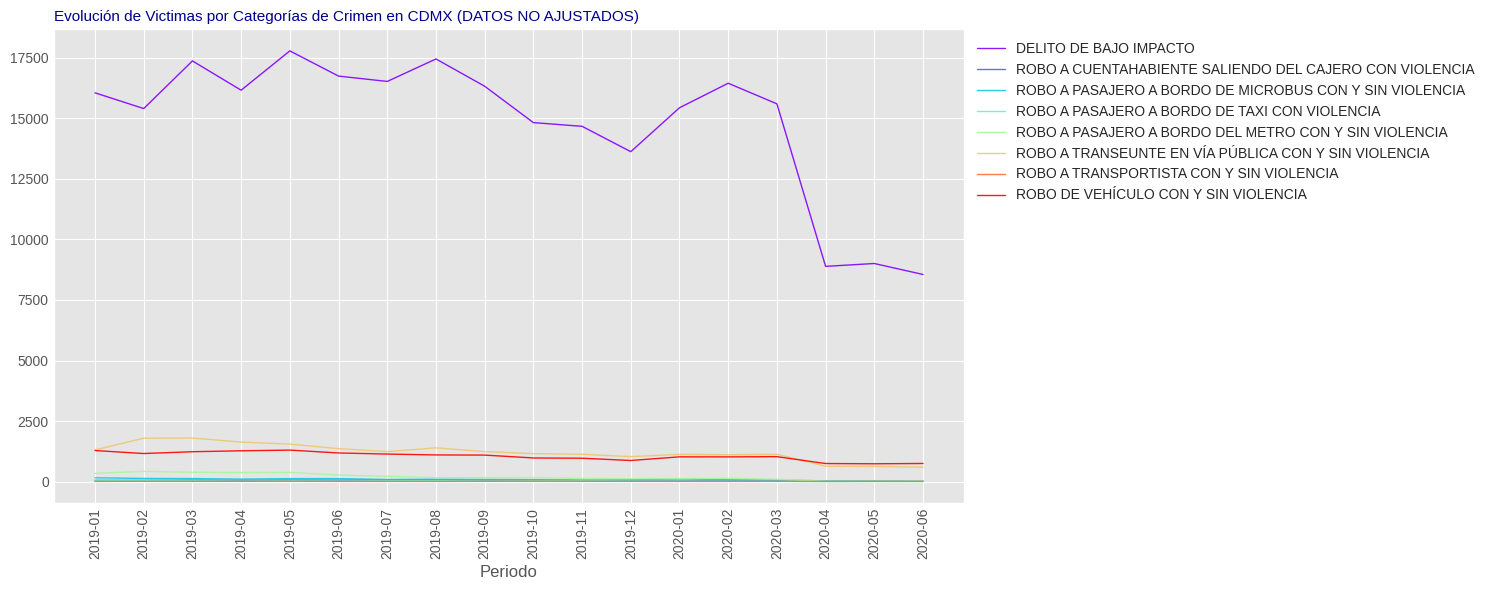

In [24]:
# Visualización

plt.style.use('ggplot') # 'ggplot', 'seaborn-darkgrid'

plt.figure( figsize = ( 15, 6 ) )

colors = cm.rainbow(np.linspace(0, 1, len(Time_Serie_OLD.columns) - 1))

# Plot multiple lines
for num, column in enumerate(Time_Serie_OLD.drop('Periodo', axis=1)):
    plt.plot(Time_Serie_OLD['Periodo'], Time_Serie_OLD[column],
             marker='', color=colors[num], linewidth=1,
             alpha=0.9, label=column)

# Add legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

# Add titles
plt.title( 'Evolución de Victimas por Categorías de Crimen en CDMX (DATOS NO AJUSTADOS)',
           loc = 'left', fontsize = 11, fontweight = 0, color = 'darkblue' )
plt.xlabel( 'Periodo' )
plt.ylabel( '' )

plt.xticks( rotation = 90 )

# Adjust layout to make room for the legend
plt.tight_layout()

In [25]:
#

Time_Serie_OLD = Time_Serie_OLD.drop('DELITO DE BAJO IMPACTO', axis=1)

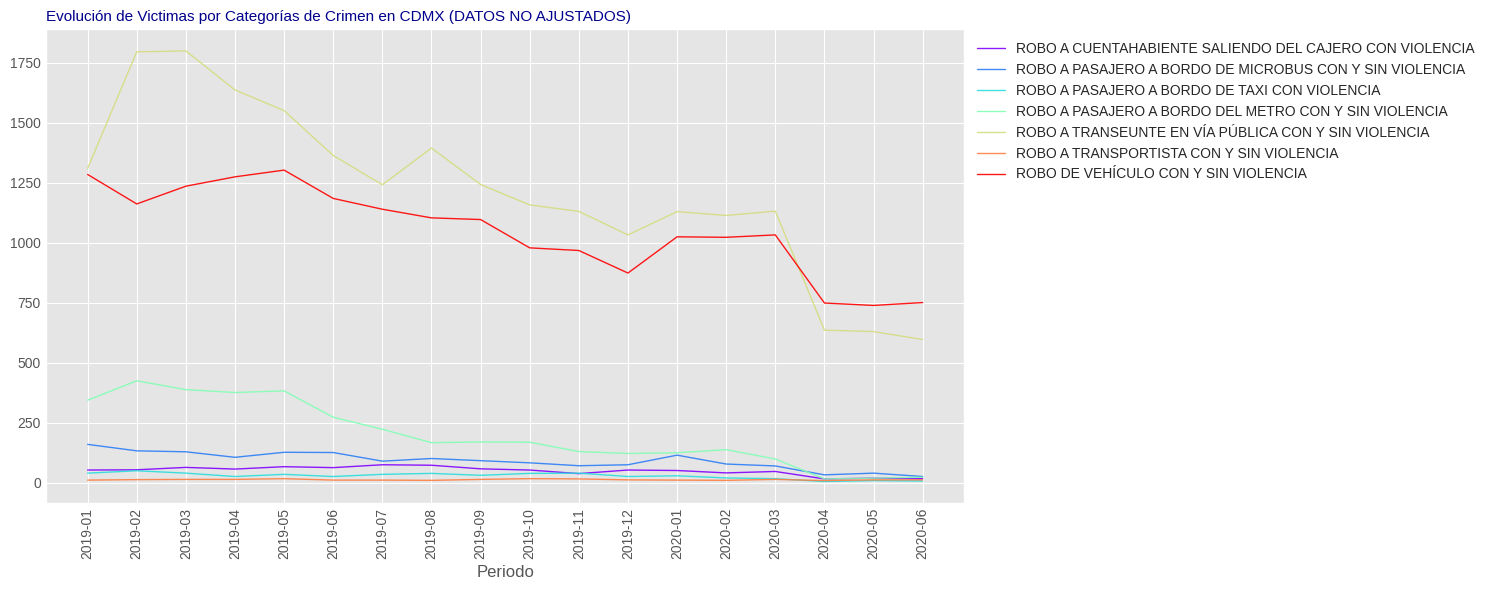

In [26]:
# Visualización

plt.style.use('ggplot') # 'ggplot', 'seaborn-darkgrid'

plt.figure( figsize = ( 15, 6 ) )

colors = cm.rainbow(np.linspace(0, 1, len(Time_Serie_OLD.columns) - 1))

# Plot multiple lines
for num, column in enumerate(Time_Serie_OLD.drop('Periodo', axis=1)):
    plt.plot(Time_Serie_OLD['Periodo'], Time_Serie_OLD[column],
             marker='', color=colors[num], linewidth=1,
             alpha=0.9, label=column)

# Add legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

# Add titles
plt.title( 'Evolución de Victimas por Categorías de Crimen en CDMX (DATOS NO AJUSTADOS)',
           loc = 'left', fontsize = 11, fontweight = 0, color = 'darkblue' )
plt.xlabel( 'Periodo' )
plt.ylabel( '' )

plt.xticks( rotation = 90 )

# Adjust layout to make room for the legend
plt.tight_layout()

## SECCIÓN II:

### Limpieza de datos

In [27]:
# Selección de información para el modelo
# Usaremos los DATOS ACTUALIZADOS:

Datos_ML = Datos[ Datos['Periodo'] >= '2019-01' ]

Datos_ML = Datos_ML[ [ 'Periodo','fecha_inicio', 'hora_inicio', 'fecha_hecho', 'hora_hecho', 'categoria_delito',
                       'sexo', 'edad', 'tipo_persona', 'calidad_juridica', 'latitud', 'longitud' ] ]

Datos_ML.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1383157 entries, 3 to 1415762
Data columns (total 12 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Periodo           1383157 non-null  object 
 1   fecha_inicio      1383157 non-null  object 
 2   hora_inicio       1383156 non-null  object 
 3   fecha_hecho       1383157 non-null  object 
 4   hora_hecho        1383156 non-null  object 
 5   categoria_delito  1383157 non-null  object 
 6   sexo              1140721 non-null  object 
 7   edad              917853 non-null   float64
 8   tipo_persona      1375885 non-null  object 
 9   calidad_juridica  1383156 non-null  object 
 10  latitud           1311632 non-null  float64
 11  longitud          1311632 non-null  float64
dtypes: float64(3), object(9)
memory usage: 137.2+ MB


In [28]:
#

Datos_ML.Periodo.value_counts()

,count
Periodo,
2019-05,24105
2019-03,23935
2019-08,23139
2023-03,22899
2019-01,22718
...,...
2020-07,17204
2020-06,15143
2024-09,14325


In [29]:
#

Datos_ML.categoria_delito.value_counts()

,count
categoria_delito,
DELITO DE BAJO IMPACTO,1154765
ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA,66030
ROBO DE VEHÍCULO CON Y SIN VIOLENCIA,50785
ROBO A NEGOCIO CON VIOLENCIA,25873
HECHO NO DELICTIVO,25737
ROBO A REPARTIDOR CON Y SIN VIOLENCIA,12712
VIOLACIÓN,11876
ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA,8754
HOMICIDIO DOLOSO,8106


In [30]:
#

Datos_ML.tipo_persona.value_counts()

,count
tipo_persona,
FISICA,1121320
MORAL,254565


In [31]:
#

pd.crosstab( Datos_ML['Periodo'], Datos_ML['tipo_persona'] , normalize = 'index' )

tipo_persona,FISICA,MORAL
Periodo,,
2019-01,0.801075,0.198925
2019-02,0.812526,0.187474
2019-03,0.802876,0.197124
2019-04,0.803828,0.196172
2019-05,0.803686,0.196314
...,...,...
2024-05,0.849794,0.150206
2024-06,0.838476,0.161524
2024-07,0.843240,0.156760


In [32]:
#

Datos_ML = Datos_ML[ Datos_ML['tipo_persona'] != 'MORAL' ]

In [33]:
#

Datos_ML.calidad_juridica.value_counts()

,count
calidad_juridica,
VICTIMA Y DENUNCIANTE,514719
DENUNCIANTE Y VICTIMA,389916
VICTIMA,117630
LESIONADO,47714
CADAVER,30313
OFENDIDO,18690
OFENDIDO Y DENUNCIANTE,8137
AGRAVIADO,1469
VICTIMA NIÑO,1


In [34]:
#
Datos_ML['personas'] = 'NA'
#
Datos_ML.loc[ Datos_ML['calidad_juridica'] == 'VICTIMA Y DENUNCIANTE', 'personas'] = 'Victima_y_Otra'
Datos_ML.loc[ Datos_ML['calidad_juridica'] == 'OFENDIDO Y DENUNCIANTE', 'personas'] = 'Victima_y_Otra'
Datos_ML.loc[ Datos_ML['calidad_juridica'] == 'DENUNCIANTE Y VICTIMA', 'personas'] = 'Victima_y_Otra'
#
Datos_ML.loc[ Datos_ML['calidad_juridica'] == 'VICTIMA', 'personas'] = 'Victima'
Datos_ML.loc[ Datos_ML['calidad_juridica'] == 'OFENDIDO', 'personas'] = 'Victima'
Datos_ML.loc[ Datos_ML['calidad_juridica'] == 'AGRAVIADO', 'personas'] = 'Victima'
Datos_ML.loc[ Datos_ML['calidad_juridica'] == 'LESIONADO', 'personas'] = 'Victima'
Datos_ML.loc[ Datos_ML['calidad_juridica'] == 'CADAVER', 'personas'] = 'Victima'

#Datos_ML.personas.value_counts()
Datos_ML = Datos_ML[ Datos_ML['personas'] != 'NA' ]

In [35]:
#

Datos_ML.personas.value_counts()

,count
personas,
Victima_y_Otra,912772
Victima,215816


In [36]:
# Creamos una variable de días

Datos_ML['Dias'] = ( pd.to_timedelta(
                     pd.to_datetime( Datos_ML['fecha_inicio'] + '-' + Datos_ML['hora_inicio'],
                                     format = '%Y-%m-%d-%H:%M:%S' ) - \
                     pd.to_datetime( Datos_ML['fecha_hecho'] + '-' + Datos_ML['hora_hecho'],
                                     format = '%Y-%m-%d-%H:%M:%S' )
                   ).dt.total_seconds() / 3600 ) / 24

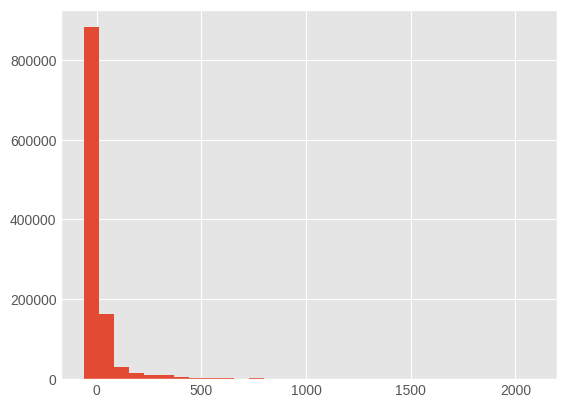

In [37]:
# Un histograma

Datos_ML['Dias'].hist( bins = 30 )

plt.show()

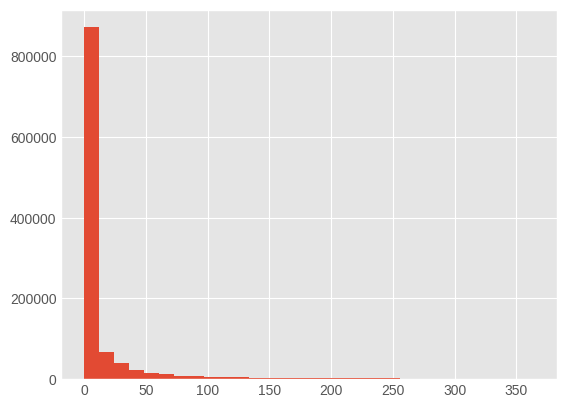

In [38]:
# Filtramos casos en los que no transcurrió más de 1 año entre la denuncia y el evento:

Datos_ML = Datos_ML[ ( Datos_ML['Dias'] >= 0 ) & ( Datos_ML['Dias'] <= 365 ) ]

Datos_ML['Dias'].hist( bins = 30 )

plt.show()

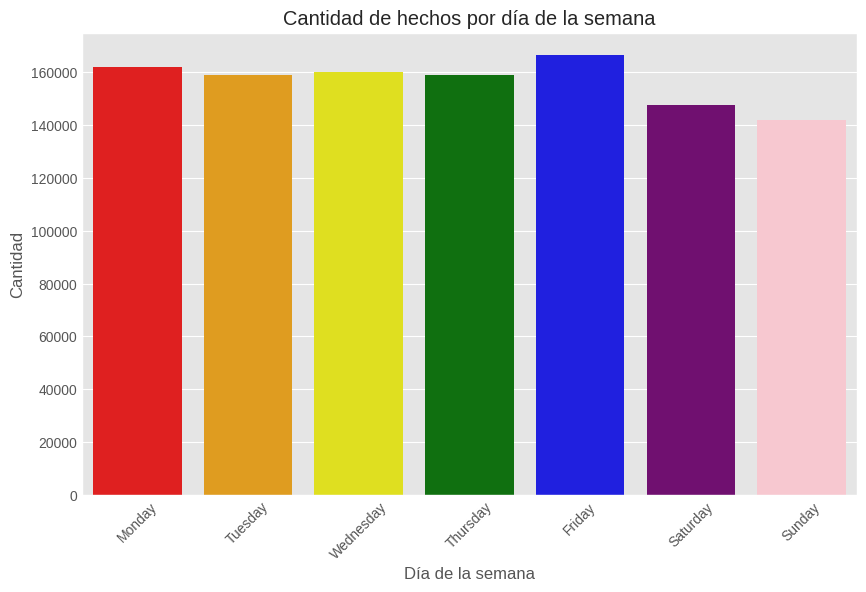

In [39]:
#
# Extraer el día de la semana

Datos_ML['fecha_hecho_dia'] = pd.to_datetime( Datos_ML['fecha_hecho'] ).dt.day_name()

colores_dias = {
    'Monday': 'red',
    'Tuesday': 'orange',
    'Wednesday': 'yellow',
    'Thursday': 'green',
    'Friday': 'blue',
    'Saturday': 'purple',
    'Sunday': 'pink'
}

# Crear el gráfico
plt.figure(figsize=(10,6))
orden_dias = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

barras = sn.countplot(
    x="fecha_hecho_dia",
    data=Datos_ML,
    order=orden_dias,  # Para que salgan en orden correcto
    palette=[colores_dias[dia] for dia in orden_dias]
)

# Mostrar
plt.title('Cantidad de hechos por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.show()

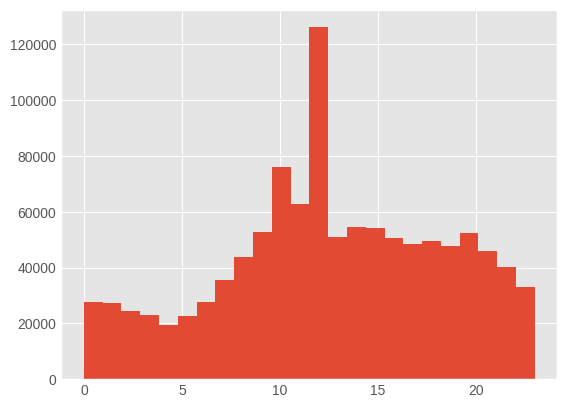

In [40]:
#
# Extraer hora

Datos_ML['hora_hecho_hora'] = pd.to_datetime( Datos_ML['hora_hecho'] ).dt.hour

Datos_ML['hora_hecho_hora'].hist( bins = 24 )

plt.show()

In [41]:
#

Datos_ML.sexo.value_counts()

,count
sexo,
Masculino,562364
Femenino,526388
No se especifica,2


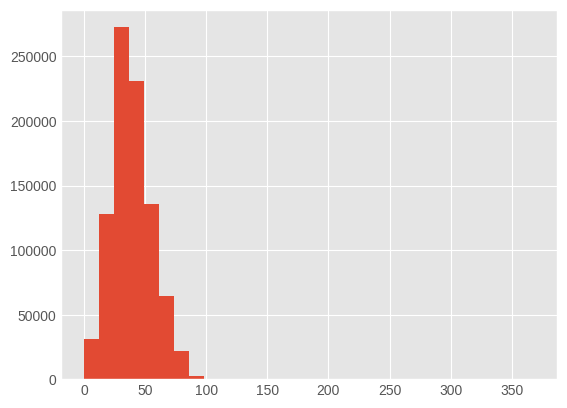

In [42]:
#

Datos_ML['edad'].hist( bins = 30 )

plt.show()

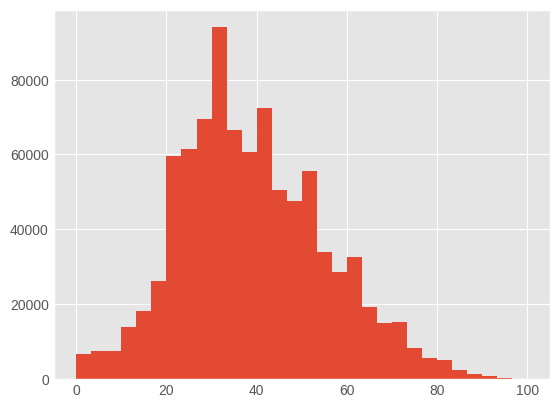

In [43]:
# Filtramos casos en los que no transcurrió más de 1 año entre la denuncia y el evento:

Datos_ML = Datos_ML[ ( Datos_ML['edad'] >= 0 ) & ( Datos_ML['edad'] <= 100 ) ]

Datos_ML['edad'].hist( bins = 30 )

plt.show()

In [44]:
#

Datos_ML.info()

<class 'pandas.core.frame.DataFrame'>
Index: 886999 entries, 3 to 1415759
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Periodo           886999 non-null  object 
 1   fecha_inicio      886999 non-null  object 
 2   hora_inicio       886999 non-null  object 
 3   fecha_hecho       886999 non-null  object 
 4   hora_hecho        886999 non-null  object 
 5   categoria_delito  886999 non-null  object 
 6   sexo              886228 non-null  object 
 7   edad              886999 non-null  float64
 8   tipo_persona      886413 non-null  object 
 9   calidad_juridica  886999 non-null  object 
 10  latitud           850603 non-null  float64
 11  longitud          850603 non-null  float64
 12  personas          886999 non-null  object 
 13  Dias              886999 non-null  float64
 14  fecha_hecho_dia   886999 non-null  object 
 15  hora_hecho_hora   886999 non-null  int32  
dtypes: float64(4), int32(1),

In [45]:
# Filtramos casos en los que no hay datos de longitud y latitud:

#Datos_ML[ ( Datos_ML['latitud'].isnull() ) | ( Datos_ML['longitud'].isnull() ) ]

Datos_ML = Datos_ML[ ( Datos_ML['latitud'].notnull() ) | ( Datos_ML['longitud'].notnull() ) ]

Datos_ML.info()

<class 'pandas.core.frame.DataFrame'>
Index: 850603 entries, 3 to 1415759
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Periodo           850603 non-null  object 
 1   fecha_inicio      850603 non-null  object 
 2   hora_inicio       850603 non-null  object 
 3   fecha_hecho       850603 non-null  object 
 4   hora_hecho        850603 non-null  object 
 5   categoria_delito  850603 non-null  object 
 6   sexo              849875 non-null  object 
 7   edad              850603 non-null  float64
 8   tipo_persona      850055 non-null  object 
 9   calidad_juridica  850603 non-null  object 
 10  latitud           850603 non-null  float64
 11  longitud          850603 non-null  float64
 12  personas          850603 non-null  object 
 13  Dias              850603 non-null  float64
 14  fecha_hecho_dia   850603 non-null  object 
 15  hora_hecho_hora   850603 non-null  int32  
dtypes: float64(4), int32(1),

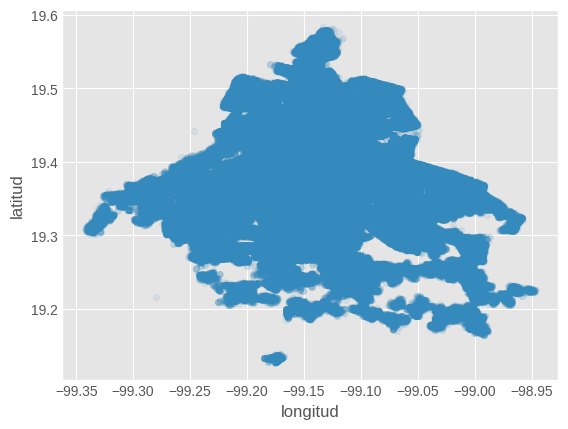

In [46]:
#

Datos_ML.plot(kind = 'scatter', x = 'longitud', y = 'latitud', alpha = 0.1)

plt.show()

In [47]:
#

Datos_ML = Datos_ML[ [ 'Periodo', 'categoria_delito', 'fecha_inicio', 'hora_inicio',
                       'fecha_hecho', 'hora_hecho', 'fecha_hecho_dia', 'hora_hecho_hora',
                       'sexo', 'edad', 'personas', 'Dias', 'latitud', 'longitud' ] ]

In [48]:
#

Datos.shape, Datos_ML.shape, 100 * Datos_ML.shape[0] / Datos.shape[0]

((1415763, 23), (850603, 14), 60.08088924488067)

## SECCIÓN III:

### Selección de datos

* Usemos los datos previos a Julio de 2020 para entrenar un modelo que permita clasificar "ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA"

In [49]:
# Agrupamos por año-mes y categoria_delito de los DATOS ACTUALIZADOS

Time_Serie_ML = Datos_ML[ ['Periodo', 'categoria_delito',
                           'fecha_inicio'] ].groupby(
                                 by = ['Periodo','categoria_delito']
                           ).count().reset_index( drop = False).rename(
                                   columns = {'categoria_delito': 'Categoria',
                                              'fecha_inicio' : 'Numero'} )

Time_Serie_ML

,Periodo,Categoria,Numero
0,2019-01,DELITO DE BAJO IMPACTO,9889
1,2019-01,HECHO NO DELICTIVO,167
2,2019-01,HOMICIDIO DOLOSO,143
3,2019-01,LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO,71
4,2019-01,ROBO A CASA HABITACIÓN CON VIOLENCIA,45
...,...,...,...
1054,2024-09,ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VI...,59
1055,2024-09,ROBO A REPARTIDOR CON Y SIN VIOLENCIA,2
1056,2024-09,ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIO...,586
1057,2024-09,ROBO DE VEHÍCULO CON Y SIN VIOLENCIA,452


In [50]:
#

Time_Serie_ML = pd.pivot_table( Time_Serie_ML, values = 'Numero', index = ['Periodo'],
                                columns = ['Categoria'], aggfunc = 'sum' ).reset_index( drop = False )

Time_Serie_ML

Categoria,Periodo,DELITO DE BAJO IMPACTO,HECHO NO DELICTIVO,HOMICIDIO DOLOSO,LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO,ROBO A CASA HABITACIÓN CON VIOLENCIA,ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA,ROBO A NEGOCIO CON VIOLENCIA,ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA,ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA,ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA,ROBO A REPARTIDOR CON Y SIN VIOLENCIA,ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA,ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA,ROBO DE VEHÍCULO CON Y SIN VIOLENCIA,SECUESTRO,VIOLACIÓN
0,2019-01,9889.0,167.0,143.0,71.0,45.0,41.0,330.0,138.0,33.0,285.0,99.0,1053.0,5.0,1098.0,15.0,58.0
1,2019-02,9757.0,198.0,129.0,85.0,64.0,45.0,268.0,113.0,46.0,339.0,65.0,1426.0,2.0,1015.0,2.0,74.0
2,2019-03,10821.0,141.0,145.0,75.0,57.0,51.0,269.0,97.0,32.0,306.0,57.0,1387.0,2.0,1070.0,6.0,87.0
3,2019-04,9993.0,171.0,138.0,65.0,56.0,43.0,237.0,79.0,17.0,295.0,50.0,1272.0,6.0,1055.0,1.0,94.0
4,2019-05,11193.0,172.0,183.0,72.0,59.0,53.0,233.0,104.0,26.0,281.0,59.0,1214.0,7.0,1073.0,8.0,87.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,2024-05,12130.0,356.0,103.0,35.0,13.0,15.0,6.0,34.0,7.0,96.0,5.0,510.0,NaN,458.0,1.0,150.0
65,2024-06,10757.0,310.0,87.0,38.0,18.0,8.0,7.0,23.0,7.0,57.0,15.0,547.0,NaN,454.0,NaN,126.0
66,2024-07,10153.0,294.0,79.0,21.0,33.0,13.0,8.0,33.0,15.0,59.0,8.0,556.0,NaN,489.0,NaN,104.0
67,2024-08,9963.0,378.0,83.0,40.0,16.0,9.0,4.0,31.0,15.0,87.0,3.0,675.0,NaN,446.0,NaN,129.0


In [51]:
#
Time_Serie_ML = Time_Serie_ML.drop('HECHO NO DELICTIVO', axis=1)
Time_Serie_ML = Time_Serie_ML.drop('SECUESTRO', axis=1)
Time_Serie_ML = Time_Serie_ML.drop('HOMICIDIO DOLOSO', axis=1)
Time_Serie_ML = Time_Serie_ML.drop('VIOLACIÓN', axis=1)
Time_Serie_ML = Time_Serie_ML.drop('LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO', axis=1)
Time_Serie_ML = Time_Serie_ML.drop('ROBO A CASA HABITACIÓN CON VIOLENCIA', axis=1)
Time_Serie_ML = Time_Serie_ML.drop('ROBO A NEGOCIO CON VIOLENCIA', axis=1)
Time_Serie_ML = Time_Serie_ML.drop('ROBO A REPARTIDOR CON Y SIN VIOLENCIA', axis=1)

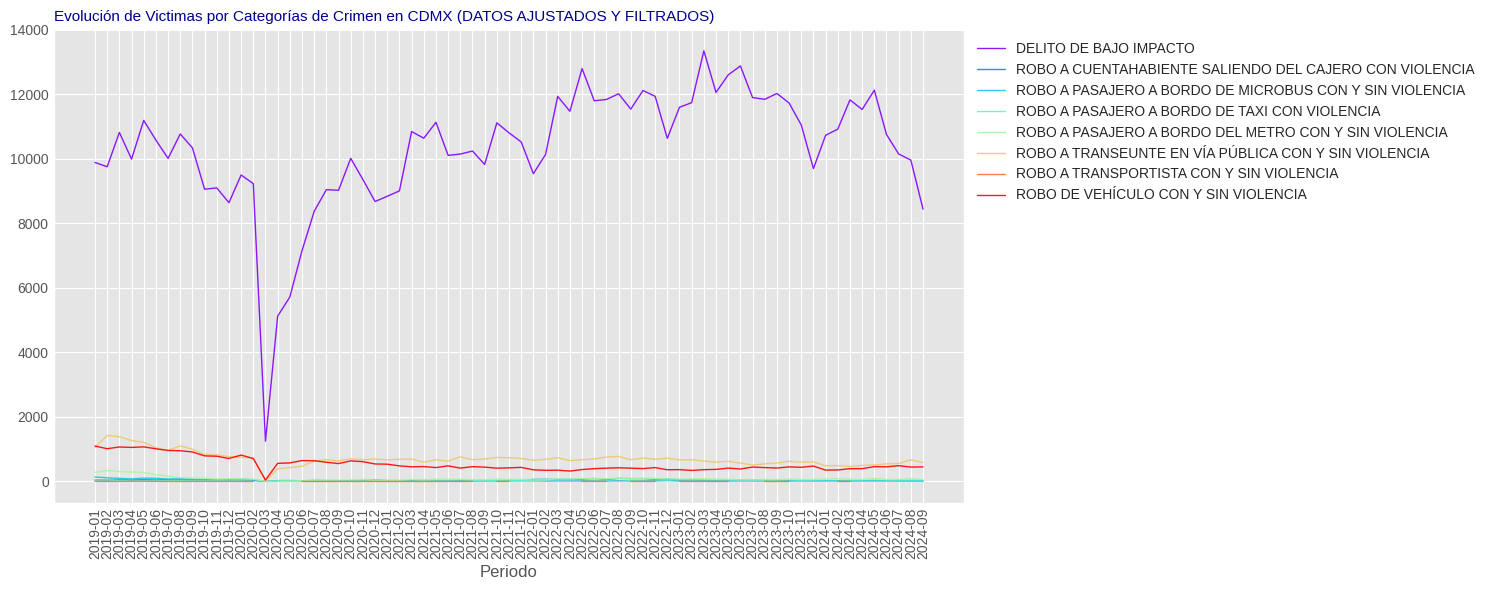

In [52]:
# Visualización

plt.style.use('ggplot') # 'ggplot', 'seaborn-darkgrid'

plt.figure( figsize = ( 15, 6 ) )

colors = cm.rainbow(np.linspace(0, 1, len(Time_Serie_ML.columns) - 1))

# Plot multiple lines
for num, column in enumerate(Time_Serie_ML.drop('Periodo', axis=1)):
    plt.plot(Time_Serie_ML['Periodo'], Time_Serie_ML[column],
             marker='', color=colors[num], linewidth=1,
             alpha=0.9, label=column)

# Add legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

# Add titles
plt.title( 'Evolución de Victimas por Categorías de Crimen en CDMX (DATOS AJUSTADOS Y FILTRADOS)',
           loc = 'left', fontsize = 11, fontweight = 0, color = 'darkblue' )
plt.xlabel( 'Periodo' )
plt.ylabel( '' )

plt.xticks( rotation = 90 )

# Adjust layout to make room for the legend
plt.tight_layout()

In [53]:
#

Time_Serie_ML = Time_Serie_ML.drop('DELITO DE BAJO IMPACTO', axis=1)

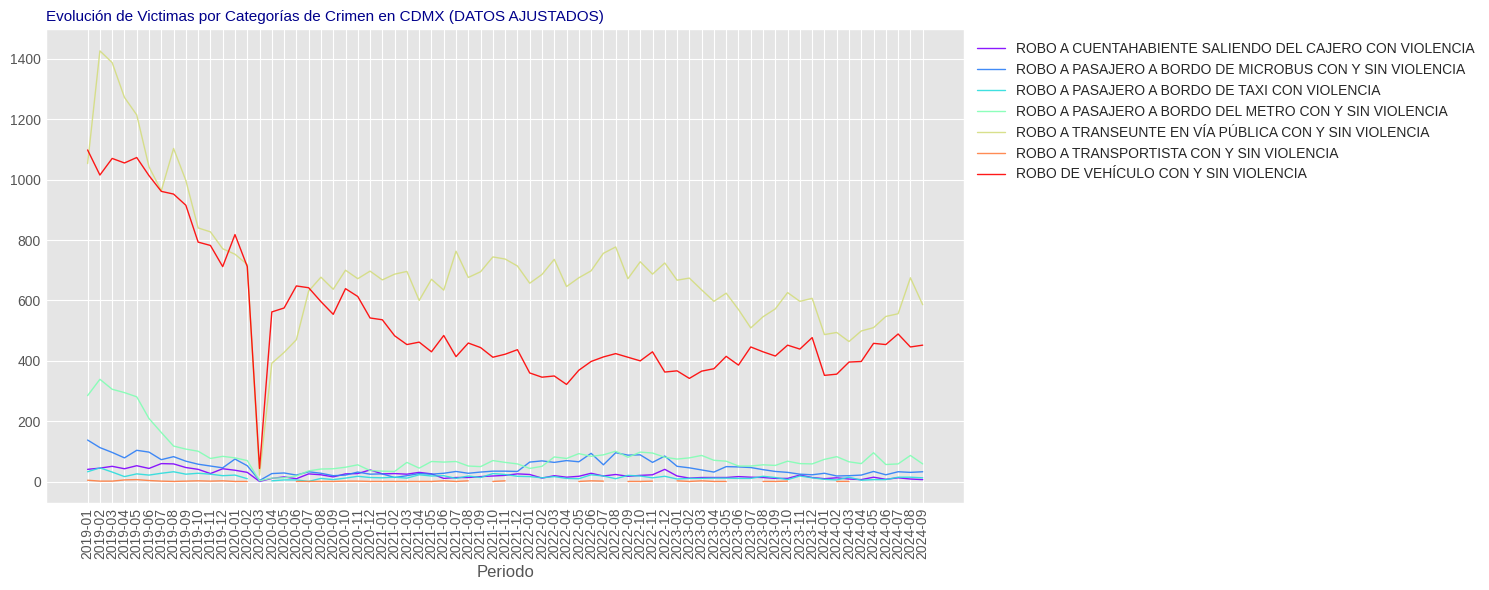

In [54]:
# Visualización

plt.style.use('ggplot') # 'ggplot', 'seaborn-darkgrid'

plt.figure( figsize = ( 15, 6 ) )

colors = cm.rainbow(np.linspace(0, 1, len(Time_Serie_ML.columns) - 1))

# Plot multiple lines
for num, column in enumerate(Time_Serie_ML.drop('Periodo', axis=1)):
    plt.plot(Time_Serie_ML['Periodo'], Time_Serie_ML[column],
             marker='', color=colors[num], linewidth=1,
             alpha=0.9, label=column)

# Add legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

# Add titles
plt.title( 'Evolución de Victimas por Categorías de Crimen en CDMX (DATOS AJUSTADOS)',
           loc = 'left', fontsize = 11, fontweight = 0, color = 'darkblue' )
plt.xlabel( 'Periodo' )
plt.ylabel( '' )

plt.xticks( rotation = 90 )

# Adjust layout to make room for the legend
plt.tight_layout()

In [55]:
# Selección de información para el modelo

# Usaremos los DATOS ACTUALIZADOS de 2019 como conjunto para entrenar y probar nuestro modelo:

Datos_01 = Datos_ML[ ( Datos_ML['Periodo'] >= '2019-01' ) & \
                     ( Datos_ML['Periodo'] <= '2019-12' ) ].reset_index( drop = True )

# Usaremos los DATOS ACTUALIZADOS de 2023 como conjunto para reclasificar delitos con nuestro modelo:

Datos_02 = Datos_ML[ ( Datos_ML['Periodo'] >= '2023-01' ) & \
                     ( Datos_ML['Periodo'] <= '2023-12' ) ].reset_index( drop = True )

#
Datos_01.shape, Datos_02.shape, 100*Datos_01.shape[0]/Datos_ML.shape[0], 100*Datos_02.shape[0]/Datos_ML.shape[0]

((158380, 14), (163471, 14), 18.619732119449377, 19.21824870121549)

In [56]:
#

Datos_01 = pd.concat( [ Datos_01, pd.get_dummies( Datos_01['sexo'], dtype = float) ], axis = 1 )

Datos_01 = pd.concat( [ Datos_01, pd.get_dummies( Datos_01['personas'], dtype = float) ], axis = 1 )

Datos_01 = pd.concat( [ Datos_01, pd.get_dummies( Datos_01['fecha_hecho_dia'].astype(str), dtype = float) ], axis = 1 )

Datos_01 = pd.concat( [ Datos_01, pd.get_dummies( Datos_01['hora_hecho_hora'].astype(str), dtype = float) ], axis = 1 )

Datos_01 = Datos_01[ [ 'Periodo', 'categoria_delito', 'fecha_hecho', 'hora_hecho',
                       'fecha_hecho_dia', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
                       'Friday', 'Saturday', 'Sunday', 'hora_hecho_hora', '0', '1', '2',
                       '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14',
                       '15', '16', '17', '18', '19', '20', '21', '22', '23', 'Dias',
                       'sexo', 'Femenino', 'Masculino', 'edad', 'personas', 'Victima',
                       'Victima_y_Otra', 'latitud', 'longitud',] ]

In [57]:
#

Datos_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158380 entries, 0 to 158379
Data columns (total 47 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Periodo           158380 non-null  object 
 1   categoria_delito  158380 non-null  object 
 2   fecha_hecho       158380 non-null  object 
 3   hora_hecho        158380 non-null  object 
 4   fecha_hecho_dia   158380 non-null  object 
 5   Monday            158380 non-null  float64
 6   Tuesday           158380 non-null  float64
 7   Wednesday         158380 non-null  float64
 8   Thursday          158380 non-null  float64
 9   Friday            158380 non-null  float64
 10  Saturday          158380 non-null  float64
 11  Sunday            158380 non-null  float64
 12  hora_hecho_hora   158380 non-null  int32  
 13  0                 158380 non-null  float64
 14  1                 158380 non-null  float64
 15  2                 158380 non-null  float64
 16  3                 15

In [58]:
#

Datos_02 = pd.concat( [ Datos_02, pd.get_dummies( Datos_02['sexo'], dtype = float) ], axis = 1 )

Datos_02 = pd.concat( [ Datos_02, pd.get_dummies( Datos_02['personas'], dtype = float) ], axis = 1 )

Datos_02 = pd.concat( [ Datos_02, pd.get_dummies( Datos_02['fecha_hecho_dia'].astype(str), dtype = float) ], axis = 1 )

Datos_02 = pd.concat( [ Datos_02, pd.get_dummies( Datos_02['hora_hecho_hora'].astype(str), dtype = float) ], axis = 1 )

Datos_02 = Datos_02[ [ 'Periodo', 'categoria_delito', 'fecha_hecho', 'hora_hecho',
                       'fecha_hecho_dia', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
                       'Friday', 'Saturday', 'Sunday', 'hora_hecho_hora', '0', '1', '2',
                       '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14',
                       '15', '16', '17', '18', '19', '20', '21', '22', '23', 'Dias',
                       'sexo', 'Femenino', 'Masculino', 'edad', 'personas', 'Victima',
                       'Victima_y_Otra', 'latitud', 'longitud',] ]

In [59]:
#

Datos_02.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163471 entries, 0 to 163470
Data columns (total 47 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Periodo           163471 non-null  object 
 1   categoria_delito  163471 non-null  object 
 2   fecha_hecho       163471 non-null  object 
 3   hora_hecho        163471 non-null  object 
 4   fecha_hecho_dia   163471 non-null  object 
 5   Monday            163471 non-null  float64
 6   Tuesday           163471 non-null  float64
 7   Wednesday         163471 non-null  float64
 8   Thursday          163471 non-null  float64
 9   Friday            163471 non-null  float64
 10  Saturday          163471 non-null  float64
 11  Sunday            163471 non-null  float64
 12  hora_hecho_hora   163471 non-null  int32  
 13  0                 163471 non-null  float64
 14  1                 163471 non-null  float64
 15  2                 163471 non-null  float64
 16  3                 16

In [60]:
#

Datos_01.describe()

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,hora_hecho_hora,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,Dias,Femenino,Masculino,edad,Victima,Victima_y_Otra,latitud,longitud
count,158380.000000,158380.000000,158380.000000,158380.000000,158380.000000,158380.000000,158380.000000,158380.000000,158380.000000,158380.000000,158380.000000,158380.000000,158380.000000,158380.000000,158380.000000,158380.000000,158380.000000,158380.000000,158380.000000,158380.000000,158380.000000,158380.000000,158380.000000,158380.000000,158380.000000,158380.000000,158380.000000,158380.000000,158380.000000,158380.000000,158380.000000,158380.000000,158380.000000,158380.000000,158380.000000,158380.000000,158380.000000,158380.000000,158380.000000,158380.000000
mean,0.144665,0.146066,0.144128,0.144204,0.153271,0.140428,0.127238,13.595056,0.020362,0.018273,0.015090,0.014465,0.012754,0.016063,0.024403,0.032776,0.039683,0.044570,0.055493,0.054066,0.075950,0.054691,0.058101,0.058391,0.054502,0.050612,0.054167,0.053132,0.058644,0.052772,0.045833,0.035206,8.717484,0.448737,0.548807,39.210317,0.191615,0.808385,19.384425,-99.135133
std,0.351764,0.353174,0.351221,0.351297,0.360249,0.347432,0.333241,5.853857,0.141237,0.133936,0.121913,0.119399,0.112212,0.125717,0.154298,0.178049,0.195214,0.206358,0.228941,0.226149,0.264919,0.227377,0.233935,0.234482,0.227006,0.219206,0.226348,0.224297,0.234957,0.223578,0.209123,0.184302,30.986192,0.497367,0.497614,15.897564,0.393573,0.393573,0.071327,0.061790
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.130790,-99.341145
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.171528,0.000000,0.000000,28.000000,0.000000,1.000000,19.335230,-99.175860
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.786111,0.000000,1.000000,37.000000,0.000000,1.000000,19.385200,-99.140073
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.258073,1.000000,1.000000,49.000000,0.000000,1.000000,19.437510,-99.095149
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,364.998611,1.000000,1.000000,100.000000,1.000000,1.000000,19.581110,-98.948320


In [61]:
#

Datos_02.describe()

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,hora_hecho_hora,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,Dias,Femenino,Masculino,edad,Victima,Victima_y_Otra,latitud,longitud
count,163471.000000,163471.000000,163471.000000,163471.000000,163471.000000,163471.000000,163471.000000,163471.000000,163471.000000,163471.000000,163471.000000,163471.000000,163471.000000,163471.000000,163471.000000,163471.000000,163471.000000,163471.000000,163471.000000,163471.000000,163471.000000,163471.000000,163471.000000,163471.000000,163471.000000,163471.000000,163471.000000,163471.000000,163471.000000,163471.000000,163471.000000,163471.000000,163471.000000,163471.000000,163471.000000,163471.000000,163471.000000,163471.000000,163471.000000,163471.000000
mean,0.145029,0.142343,0.146069,0.143420,0.145818,0.135192,0.142129,12.208545,0.016095,0.030819,0.028996,0.026433,0.023215,0.026794,0.031357,0.040490,0.048767,0.053526,0.068703,0.063589,0.087526,0.041836,0.046504,0.045672,0.044045,0.042399,0.041836,0.042197,0.048259,0.040356,0.033088,0.027497,12.282543,0.524784,0.475148,39.367729,0.136746,0.863254,19.381216,-99.134893
std,0.352131,0.349403,0.353176,0.350502,0.352925,0.341930,0.349184,6.046078,0.125840,0.172827,0.167796,0.160419,0.150587,0.161481,0.174282,0.197107,0.215381,0.225081,0.252950,0.244021,0.282606,0.200215,0.210574,0.208773,0.205195,0.201498,0.200215,0.201039,0.214314,0.196793,0.178868,0.163528,37.798958,0.499387,0.499384,16.275013,0.343580,0.343580,0.073671,0.063783
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.126574,-99.341338
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.289149,0.000000,0.000000,28.000000,0.000000,1.000000,19.328609,-99.174981
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.410764,1.000000,0.000000,37.000000,0.000000,1.000000,19.383482,-99.138287
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.245700,1.000000,1.000000,50.000000,0.000000,1.000000,19.436379,-99.093855
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,364.997222,1.000000,1.000000,100.000000,1.000000,1.000000,19.579410,-98.948363


## SECCIÓN IV:

### Modelado

* Usemos los datos previos a Julio de 2020 para entrenar un modelo que permita clasificar "ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA"

* Plantearemos un modelo de respuesta binaria:

Este tipo de modelos suponene que existe una variable latente que se puede expresar como una ecuación lineal dada por:
$$y^*_i = \mathbf{x}_i \boldsymbol{\beta} + \varepsilon_i$$

Donde $\varepsilon_i$ es una variable aleatoria con función de densidad con media cero y distribución simetrica al rededor de cero. Dado lo anterior, para nosotros sólo es visible que:
\begin{equation*}
    y_i =
    \begin{cases}
        1 & \text{si } y^*_i > 0 \\
        0 & \text{si } y^*_i < 0
    \end{cases}
\end{equation*}

Visto en nuestro caso, podemos pensar que estamos ante algo como:
\begin{equation*}
    y_i =
    \begin{cases}
        \text{ ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA } & \text{si } y^*_i > 0 \\
        \text{ OTRO CASO } & \text{si } y^*_i < 0
    \end{cases}
\end{equation*}

De esta forma tenemos una estrucutura de la probabilidad dada por:
\begin{eqnarray*}
    P(y_i = 1 | \mathbf{x}_i) & = & P(\mathbf{x}_i \boldsymbol{\beta} + \varepsilon_i > 0) = P(\varepsilon_i > - \mathbf{x}_i \boldsymbol{\beta}) = G(\mathbf{x}_i \boldsymbol{\beta}) \\
    P(y_i = 0 | \mathbf{x}_i) & = & P(\mathbf{x}_i \boldsymbol{\beta} + \varepsilon_i < 0) = P(\varepsilon_i < - \mathbf{x}_i \boldsymbol{\beta}) = 1 - G(\mathbf{x}_i \boldsymbol{\beta})
\end{eqnarray*}

Donde $\mathbf{x}_i$ es un vector de dimensión $K \times 1$ que contiene al menos el término constante y $\boldsymbol{\beta}$ es un vector de parámetros a estimar, de forma que asumiremos:
\begin{equation*}
    \mathbf{x}_i \boldsymbol{\beta} = \beta_1 + x_{i2} \beta_2 + \ldots + x_{iK} \beta_K
\end{equation*}

Asumiremos que $G(\cdot)$ es uan función de densidad acumulada de forma que:
\begin{equation*}
    0< G(\mathbf{x}_i \boldsymbol{\beta}) < 1 \text{ , } \forall \mathbf{x}_i \boldsymbol{\beta} \in \mathbb{R}
\end{equation*}

En este caso utilizaremos dos modelos que dependen de la forma funcional de $G(\cdot)$ que está determinada por la distribución de $\varepsilon_i$. De esta forma tendremos dos modelos: Probit y Logit.

In [62]:
#
Datos_01.shape

(158380, 47)

In [63]:
# Seleccionamos solo los casos de interés para Dataset 01

Datos_01 = Datos_01[ ( Datos_01['categoria_delito'] == 'DELITO DE BAJO IMPACTO' ) | \
                     ( Datos_01['categoria_delito'] == 'ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA' ) ]

# Variable categórica:
Datos_01[ 'Delito' ] = 0

Datos_01.loc[ Datos_01['categoria_delito'] == 'ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA', 'Delito'] = 1

In [64]:
#
Datos_01.shape

(133067, 48)

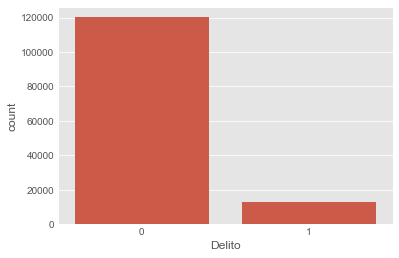

In [ ]:
#

sn.countplot( x = 'Delito', data = Datos_01)

plt.show()

In [65]:
#
Datos_01.Delito.describe()

,Delito
count,133067.000000
mean,0.096906
std,0.295831
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [66]:
#
Datos_02.shape

(163471, 47)

In [67]:
# Seleccionamos solo los casos de interés para Dataset 02

Datos_02 = Datos_02[ ( Datos_02['categoria_delito'] == 'DELITO DE BAJO IMPACTO' ) | \
                     ( Datos_02['categoria_delito'] == 'ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA' ) ]

# Variable categórica:
Datos_02[ 'Delito' ] = 0

Datos_02.loc[ Datos_02['categoria_delito'] == 'ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA', 'Delito'] = 1

In [68]:
#
Datos_02.shape

(149734, 48)

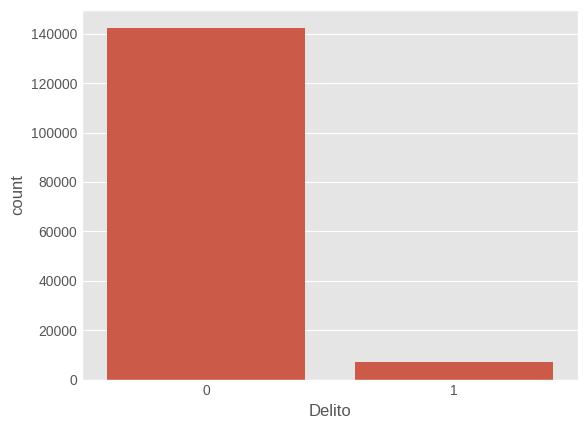

In [69]:
#

sn.countplot( x = 'Delito', data = Datos_02)

plt.show()

In [ ]:
#
Datos_02.Delito.describe()

count    149734.000000
mean          0.048246
std           0.214285
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Delito, dtype: float64

### Logistic Regression
Logistic regression is a type of regression analysis in statistics used for prediction of outcome of a categorical dependent variable from a set of predictor or independent variables. In logistic regression the dependent variable is always binary. Logistic regression is mainly used to for prediction and also calculating the probability of success.

In [70]:
# Add constant

Datos_01[ 'Constante' ] = 1

In [71]:
# Selecciones las columnas de nuestra regresión:

Datos_01.columns

Index(['Periodo', 'categoria_delito', 'fecha_hecho', 'hora_hecho',
       'fecha_hecho_dia', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'Saturday', 'Sunday', 'hora_hecho_hora', '0', '1', '2', '3',
       '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16',
       '17', '18', '19', '20', '21', '22', '23', 'Dias', 'sexo', 'Femenino',
       'Masculino', 'edad', 'personas', 'Victima', 'Victima_y_Otra', 'latitud',
       'longitud', 'Delito', 'Constante'],
      dtype='object')

In [72]:
# Model

model = sm.Logit(
    Datos_01.Delito, # Y
    Datos_01[[ 'Constante',
               'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', # Quitamos el domingo
               '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14',
               '15', '16', '17', '18', '19', '20', '21', '22', '23', # Quitamos la hora 0
               'Femenino', # Quitamos la dummy de masculino
               'Victima', # Quitamos la dummy de cuando la denuncia la hace alguien más que la victima
               'Dias', 'edad', 'latitud', 'longitud']]
)

result = model.fit()

result.summary()

Optimization terminated successfully.
         Current function value: 0.281793
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Delito   No. Observations:               133067
Model:                          Logit   Df Residuals:                   133031
Method:                           MLE   Df Model:                           35
Date:                Fri, 27 Feb 2026   Pseudo R-squ.:                  0.1145
Time:                        23:16:47   Log-Likelihood:                -37497.
converged:                       True   LL-Null:                       -42346.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constante    372.5574     15.873     23.472      0.000     341.448     403.667
Monday         0.3152      0.038      8.316      0.000       0.241       0.390
Tuesday        0.2233      0.038      5.816      0.000       0.148       0.299
Wednesday      0.2194      0.039      5.685      0.000       0.144       0.295
Thursday       0.2245      0.039      5.815      0.000       0.149       0.300
Friday         0.2056      0.038      5.433      0.000       0.131       0.280
Saturday       0.1870      0.038      4.861      0.000       0.112       0.262
1             -0.1352      0.094     -1.431      0.152      -0.320       0.050
2             -0.2086      0.103     -2.029      0.043      -0.410      -0.007
3             -0.3302      0.105     -3.130      0.002      -0.537      -0.123
4             -0.0119      0.102     -0.116      0.907      -0.212       0.188
5              0.2423      0.094      2.586      0.010       0.059       0.426
6              0.2546      0.084      3.021      0.003       0.089       0.420
7             -0.2405      0.085     -2.834      0.005      -0.407      -0.074
8             -0.4448      0.084     -5.299      0.000      -0.609      -0.280
9             -0.5092      0.083     -6.134      0.000      -0.672      -0.346
10            -0.4876      0.080     -6.085      0.000      -0.645      -0.331
11            -0.3159      0.078     -4.036      0.000      -0.469      -0.162
12            -0.4543      0.077     -5.904      0.000      -0.605      -0.303
13            -0.0145      0.076     -0.192      0.848      -0.163       0.134
14            -0.1659      0.076     -2.182      0.029      -0.315      -0.017
15            -0.1340      0.076     -1.771      0.077      -0.282       0.014
16            -0.1486      0.076     -1.946      0.052      -0.298       0.001
17            -0.2353      0.078     -3.013      0.003      -0.388      -0.082
18            -0.3019      0.078     -3.875      0.000      -0.455      -0.149
19            -0.0866      0.076     -1.138      0.255      -0.236       0.063
20            -0.0442      0.075     -0.590      0.555      -0.191       0.102
21             0.0875      0.075      1.166      0.244      -0.060       0.235
22             0.0207      0.077      0.270      0.787      -0.129       0.171
23             0.0036      0.080      0.045      0.964      -0.153       0.161
Femenino      -0.7415      0.020    -36.951      0.000      -0.781      -0.702
Victima       -2.2916      0.048    -48.030      0.000      -2.385      -2.198
Dias          -0.0248      0.001    -20.197      0.000      -0.027      -0.022
edad          -0.0350      0.001    -45.831      0.000      -0.037      -0.034
latitud        2.7910      0.142     19.720      0.000       2.514       3.068
longitud       4.3072      0.164     26.334      0.000       3.987       4.628
==============================================================================
"""

In [73]:
#

print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                 Delito   No. Observations:               133067
Model:                          Logit   Df Residuals:                   133031
Method:                           MLE   Df Model:                           35
Date:                Fri, 27 Feb 2026   Pseudo R-squ.:                  0.1145
Time:                        23:16:59   Log-Likelihood:                -37497.
converged:                       True   LL-Null:                       -42346.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constante    372.5574     15.873     23.472      0.000     341.448     403.667
Monday         0.3152      0.038      8.316      0.000       0.241       0.390
Tuesday        0.2233      0.038      5.816      0.0

In [74]:
# Rebalanceamos la muestra:

# 1. Selección de muestra 32% del caso delito 0
Datos_01_train, Datos_01_test = train_test_split( Datos_01[ Datos_01['Delito'] == 0 ],
                                                  test_size = 0.68, random_state = 42 )

# 2. Juntamos delitos 0 y 1
Datos_01_train = pd.concat( [ Datos_01[ Datos_01['Delito'] == 1 ], Datos_01_train ], ignore_index = True )

Datos_01.shape, Datos_01_train.shape

((133067, 49), (51350, 49))

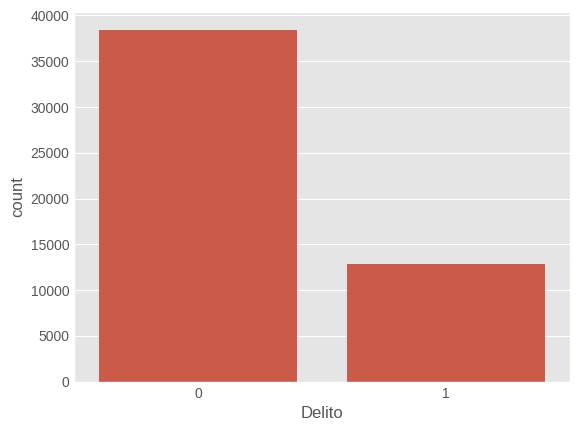

In [75]:
#

sn.countplot( x = 'Delito', data = Datos_01_train)

plt.show()

In [76]:
#
Datos_01_train.Delito.describe()

,Delito
count,51350.000000
mean,0.251120
std,0.433661
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [77]:
#
Datos_01_train.describe()

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,hora_hecho_hora,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,Dias,Femenino,Masculino,edad,Victima,Victima_y_Otra,latitud,longitud,Delito,Constante
count,51350.000000,51350.000000,51350.000000,51350.000000,51350.000000,51350.000000,51350.000000,51350.000000,51350.000000,51350.000000,51350.000000,51350.000000,51350.000000,51350.000000,51350.000000,51350.000000,51350.000000,51350.000000,51350.000000,51350.000000,51350.000000,51350.000000,51350.000000,51350.000000,51350.000000,51350.000000,51350.000000,51350.000000,51350.000000,51350.000000,51350.000000,51350.000000,51350.000000,51350.000000,51350.000000,51350.000000,51350.000000,51350.000000,51350.000000,51350.000000,51350.000000,51350.0
mean,0.146056,0.146368,0.143038,0.142395,0.154528,0.142142,0.125472,13.690185,0.019357,0.017683,0.014742,0.013301,0.012717,0.015209,0.022726,0.031159,0.037644,0.043135,0.055463,0.055054,0.076981,0.056319,0.060701,0.059396,0.057799,0.050730,0.053982,0.051665,0.059552,0.053749,0.046329,0.034606,8.621312,0.464284,0.533165,38.375073,0.166310,0.833690,19.385811,-99.134338,0.251120,1.0
std,0.353166,0.353478,0.350115,0.349459,0.361457,0.349199,0.331257,5.790775,0.137779,0.131796,0.120519,0.114561,0.112050,0.122386,0.149031,0.173748,0.190335,0.203164,0.228883,0.228087,0.266565,0.230540,0.238784,0.236367,0.233366,0.219449,0.225985,0.221352,0.236657,0.225523,0.210199,0.182781,30.781959,0.498728,0.498904,15.639999,0.372362,0.372362,0.070578,0.061564,0.433661,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.130893,-99.339686,0.000000,1.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.161111,0.000000,0.000000,27.000000,0.000000,1.000000,19.337950,-99.175150,0.000000,1.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.804763,0.000000,1.000000,36.000000,0.000000,1.000000,19.387240,-99.139110,0.000000,1.0
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.308576,1.000000,1.000000,48.000000,0.000000,1.000000,19.437931,-99.094853,1.000000,1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,364.994954,1.000000,1.000000,100.000000,1.000000,1.000000,19.579550,-98.949310,1.000000,1.0


In [78]:
#
Datos_01.describe()

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,hora_hecho_hora,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,Dias,Femenino,Masculino,edad,Victima,Victima_y_Otra,latitud,longitud,Delito,Constante
count,133067.000000,133067.000000,133067.000000,133067.000000,133067.000000,133067.000000,133067.000000,133067.000000,133067.000000,133067.000000,133067.000000,133067.000000,133067.000000,133067.000000,133067.000000,133067.000000,133067.000000,133067.000000,133067.000000,133067.000000,133067.000000,133067.000000,133067.000000,133067.000000,133067.000000,133067.000000,133067.000000,133067.000000,133067.000000,133067.000000,133067.000000,133067.000000,133067.000000,133067.000000,133067.000000,133067.000000,133067.000000,133067.000000,133067.000000,133067.000000,133067.000000,133067.0
mean,0.144784,0.146212,0.143604,0.142552,0.153652,0.141154,0.128041,13.619718,0.019171,0.017487,0.014316,0.013790,0.011874,0.013707,0.021515,0.030443,0.037973,0.045383,0.058542,0.056490,0.082297,0.057107,0.060887,0.060571,0.056618,0.051485,0.054409,0.052440,0.056753,0.049501,0.043925,0.033314,9.707289,0.486822,0.510630,39.405720,0.192933,0.807067,19.384204,-99.136739,0.096906,1.0
std,0.351884,0.353320,0.350689,0.349617,0.360616,0.348182,0.334136,5.719114,0.137126,0.131079,0.118791,0.116619,0.108318,0.116274,0.145096,0.171804,0.191133,0.208144,0.234766,0.230867,0.274818,0.232047,0.239123,0.238543,0.231112,0.220986,0.226823,0.222913,0.231372,0.216913,0.204930,0.179456,32.860130,0.499828,0.499889,16.143771,0.394602,0.394602,0.071028,0.061567,0.295831,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.130790,-99.341145,0.000000,1.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.187894,0.000000,0.000000,28.000000,0.000000,1.000000,19.335170,-99.176840,0.000000,1.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.888090,0.000000,1.000000,38.000000,0.000000,1.000000,19.385430,-99.141580,0.000000,1.0
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.933501,1.000000,1.000000,50.000000,0.000000,1.000000,19.437022,-99.097415,0.000000,1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,364.994954,1.000000,1.000000,100.000000,1.000000,1.000000,19.581110,-98.948320,1.000000,1.0


In [79]:
# Model

model_adj = sm.Logit(
    Datos_01_train.Delito,
    Datos_01_train[[ 'Constante',
                     'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', # Quitamos el domingo
                     '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14',
                     '15', '16', '17', '18', '19', '20', '21', '22', '23', # Quitamos la hora 0
                     'Femenino', # Quitamos la dummy de masculino
                     'Victima', # Quitamos la dummy de cuando la denuncia la hace alguien más que la victima
                     'Dias', 'edad', 'latitud', 'longitud']]
)

result_adj = model_adj.fit()
print(result_adj.summary())

Optimization terminated successfully.
         Current function value: 0.486255
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 Delito   No. Observations:                51350
Model:                          Logit   Df Residuals:                    51314
Method:                           MLE   Df Model:                           35
Date:                Fri, 27 Feb 2026   Pseudo R-squ.:                  0.1372
Time:                        23:17:24   Log-Likelihood:                -24969.
converged:                       True   LL-Null:                       -28939.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constante    363.5355     18.065     20.124      0.000     328.129     398.942
Monday         0.3389      0.

### Implementemos / entrenemos nuestro modelo

In [80]:
#

X = Datos_01_train[[ 'Constante', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
                     '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14',
                     '15', '16', '17', '18', '19', '20', '21', '22', '23',
                     'Femenino', 'Victima', 'Dias', 'edad', 'latitud', 'longitud']]
y = Datos_01_train.Delito

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.20, random_state = 5)

In [81]:
# Del sklearn

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

In [82]:
# Model accuracy

accuracy_score( y_test, y_pred )

0.7546251217137293

In [83]:
# Confusion matrix

cm = confusion_matrix( y_test, y_pred )

conf_matrix = pd.DataFrame( data = cm,
                            columns = ['Predicted:0','Predicted:1'],
                            index = ['Actual:0','Actual:1'] )

conf_matrix

,Predicted:0,Predicted:1
Actual:0,7313,347
Actual:1,2173,437


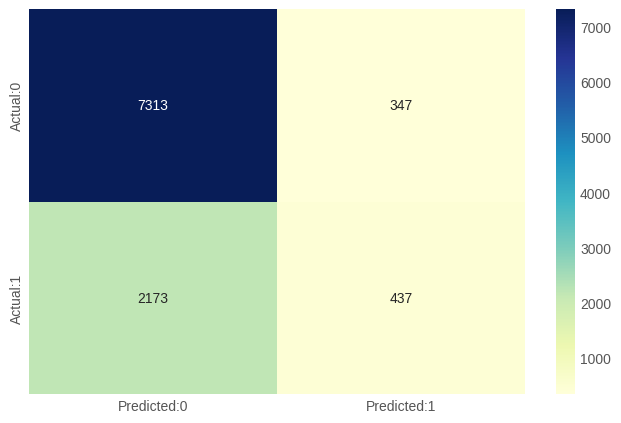

In [84]:
#

plt.figure( figsize = (8,5) )

sn.heatmap( conf_matrix, annot = True, fmt = 'd', cmap = "YlGnBu" )

plt.show()

In [85]:
# accuracy

(7316 + 430) / (7316 + 430 + 344 + 2180)

0.7542356377799416

In [86]:
# Model Evaluation - Statistics

TN=cm[0,0]
TP=cm[1,1]
FN=cm[1,0]
FP=cm[0,1]
sensitivity=TP/float(TP+FN)
specificity=TN/float(TN+FP)

print('The acuuracy of the model = TP+TN/(TP+TN+FP+FN) = ',(TP+TN)/float(TP+TN+FP+FN),'\n',

'The Missclassification = 1-Accuracy = ',1-((TP+TN)/float(TP+TN+FP+FN)),'\n',

'Sensitivity or True Positive Rate = TP/(TP+FN) = ',TP/float(TP+FN),'\n',

'Specificity or True Negative Rate = TN/(TN+FP) = ',TN/float(TN+FP),'\n',

'Positive Predictive value = TP/(TP+FP) = ',TP/float(TP+FP),'\n',

'Negative predictive Value = TN/(TN+FN) = ',TN/float(TN+FN),'\n',

'Positive Likelihood Ratio = Sensitivity/(1-Specificity) = ',sensitivity/(1-specificity),'\n',

'Negative likelihood Ratio = (1-Sensitivity)/Specificity = ',(1-sensitivity)/specificity)

The acuuracy of the model = TP+TN/(TP+TN+FP+FN) =  0.7546251217137293 
 The Missclassification = 1-Accuracy =  0.2453748782862707 
 Sensitivity or True Positive Rate = TP/(TP+FN) =  0.1674329501915709 
 Specificity or True Negative Rate = TN/(TN+FP) =  0.9546997389033942 
 Positive Predictive value = TP/(TP+FP) =  0.5573979591836735 
 Negative predictive Value = TN/(TN+FN) =  0.7709255745308876 
 Positive Likelihood Ratio = Sensitivity/(1-Specificity) =  3.696070312586259 
 Negative likelihood Ratio = (1-Sensitivity)/Specificity =  0.8720721457038927


In [87]:
# Calculamos las probabiliades:

y_pred_prob    = logreg.predict_proba( X_test )[: , :]

y_pred_prob_df = pd.DataFrame( data = y_pred_prob,
                               columns = ['Prob de delito bajo impacto (0)','Prob de robo (1)'] )

y_pred_prob_df.head()

,Prob de delito bajo impacto (0),Prob de robo (1)
0,0.896596,0.103404
1,0.960568,0.039432
2,0.622417,0.377583
3,0.457265,0.542735
4,0.681006,0.318994


### ROC curve

Una forma común de visualizar las compensaciones de diferentes umbrales es mediante el uso de una curva ROC, un gráfico de la tasa de verdaderos positivos (# verdaderos positivos/# total de positivos) versus la tasa de falsos positivos (# falsos positivos/# total de negativos) para todas las opciones posibles de umbrales. Un modelo con buena precisión de clasificación debería tener significativamente más positivos verdaderos que falsos positivos en todos los umbrales.

La posición óptima para la curva roc es hacia la esquina superior izquierda, donde la especificidad y la sensibilidad están en niveles óptimos.

Área bajo la curva (AUC). El área bajo la curva ROC cuantifica la precisión de la clasificación del modelo; cuanto mayor sea el área, mayor será la disparidad entre los verdaderos y falsos positivos, y más fuerte será el modelo para clasificar los miembros del conjunto de datos de entrenamiento. Un área de 0,5 corresponde a un modelo que no funciona mejor que la clasificación aleatoria y un buen clasificador se mantiene lo más lejos posible de eso. Un área de 1 es ideal. Cuanto más cerca esté el AUC de 1, mejor.

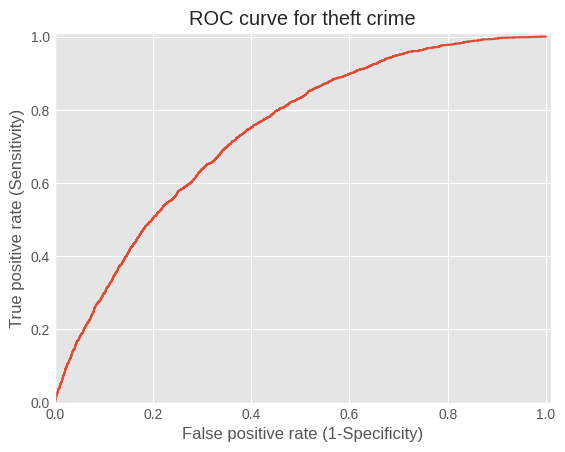

In [88]:
#

fpr, tpr, thresholds = roc_curve( y_test, y_pred_prob_df.iloc[:,1] )

#
plt.plot(fpr,tpr)
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.title('ROC curve for theft crime')
plt.xlabel('False positive rate (1-Specificity)')
plt.ylabel('True positive rate (Sensitivity)')
plt.grid(True)

In [89]:
#

roc_auc_score(y_test, y_pred_prob_df.iloc[:,1])

np.float64(0.7380905935196023)

## SECCIÓN V:

### Prediciendo sobre el dataset que queremos clasificar

* Usemos los datos de 2023 para clasificar "ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA"

In [90]:
# Seleccionamos solo los casos de interés para Dataset 02

Datos_02 = Datos_02[ ( Datos_02['categoria_delito'] == 'DELITO DE BAJO IMPACTO' ) | \
                     ( Datos_02['categoria_delito'] == 'ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA' ) ]

# Variable categórica:
Datos_02[ 'Delito' ] = 0

Datos_02.loc[ Datos_02['categoria_delito'] == 'ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA', 'Delito'] = 1

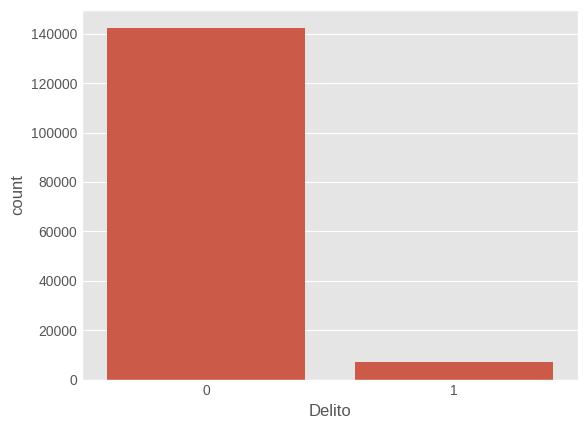

In [91]:
#

sn.countplot( x = 'Delito', data = Datos_02)

plt.show()

In [92]:
#

Datos_02.describe()

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,hora_hecho_hora,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,Dias,Femenino,Masculino,edad,Victima,Victima_y_Otra,latitud,longitud,Delito
count,149734.000000,149734.000000,149734.000000,149734.000000,149734.000000,149734.000000,149734.000000,149734.000000,149734.000000,149734.000000,149734.000000,149734.000000,149734.000000,149734.000000,149734.000000,149734.000000,149734.000000,149734.000000,149734.000000,149734.000000,149734.000000,149734.000000,149734.000000,149734.000000,149734.000000,149734.000000,149734.000000,149734.000000,149734.000000,149734.000000,149734.00000,149734.000000,149734.000000,149734.000000,149734.000000,149734.000000,149734.000000,149734.000000,149734.000000,149734.000000,149734.000000
mean,0.145471,0.142713,0.146006,0.143501,0.145952,0.134545,0.141811,12.166669,0.014646,0.030835,0.028657,0.026353,0.023101,0.026380,0.030808,0.040231,0.048860,0.054690,0.070966,0.066010,0.090961,0.042242,0.046790,0.046075,0.043631,0.042228,0.041387,0.041467,0.047077,0.038775,0.03173,0.026100,12.744275,0.542970,0.456970,39.385216,0.111304,0.888696,19.381560,-99.135890,0.048246
std,0.352577,0.349781,0.353113,0.350584,0.353059,0.341238,0.348858,5.977212,0.120131,0.172870,0.166843,0.160184,0.150225,0.160263,0.172798,0.196502,0.215576,0.227376,0.256769,0.248301,0.287555,0.201140,0.211189,0.209648,0.204273,0.201110,0.199184,0.199368,0.211804,0.193060,0.17528,0.159432,38.342073,0.498152,0.498147,16.127960,0.314509,0.314509,0.073260,0.063561,0.214285
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.126574,-99.341338,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.334806,0.000000,0.000000,28.000000,0.000000,1.000000,19.329288,-99.175713,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.568999,1.000000,0.000000,37.000000,0.000000,1.000000,19.384299,-99.139356,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,5.692367,1.000000,1.000000,50.000000,0.000000,1.000000,19.436360,-99.095135,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,364.989271,1.000000,1.000000,99.000000,1.000000,1.000000,19.579410,-98.948363,1.000000


In [93]:
#

Datos_02[ 'Constante' ] = 1

X_New = Datos_02[[ 'Constante', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
                   '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14',
                   '15', '16', '17', '18', '19', '20', '21', '22', '23',
                   'Femenino', 'Victima', 'Dias', 'edad', 'latitud', 'longitud']]

Datos_02[ 'Delito_Predict' ] = logreg.predict(X_New)

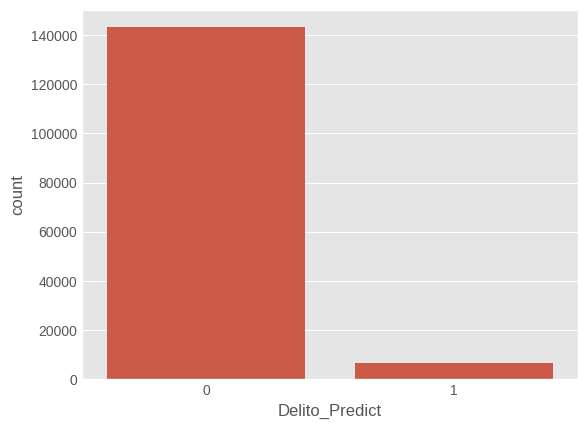

In [94]:
#

sn.countplot( x = 'Delito_Predict', data = Datos_02)

plt.show()

In [95]:
#

Datos_02[ ['Delito', 'Delito_Predict'] ].describe()

,Delito,Delito_Predict
count,149734.000000,149734.000000
mean,0.048246,0.044626
std,0.214285,0.206482
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


## SECCIÓN VI:

### Prediciendo sobre el dataset que queremos clasificar OLD

* Usemos los datos antes de la re-clasificación"

In [96]:
#

Datos_OLD.Periodo.value_counts()

,count
Periodo,
2019-05,23647
2019-03,23546
2019-08,22587
2019-01,22161
2019-04,22047
...,...
2007-06,1
1974-07,1
2000-11,1


In [97]:
# Selección de información para el modelo
# Usaremos los DATOS ACTUALIZADOS:

Datos_OLD_ML = Datos_OLD[ Datos_OLD['Periodo'] >= '2019-01' ]

Datos_OLD_ML = Datos_OLD_ML[ [ 'Periodo','FechaInicio', 'HoraInicio', 'FechaHecho', 'HoraHecho', 'Categoria',
                               'Sexo', 'Edad', 'TipoPersona', 'CalidadJuridica', 'latitud', 'longitud' ] ]


In [98]:
#

original = [ 'Periodo','FechaInicio', 'HoraInicio', 'FechaHecho', 'HoraHecho', 'Categoria',
             'Sexo', 'Edad', 'TipoPersona', 'CalidadJuridica', 'latitud', 'longitud' ]

nuevo = [ 'Periodo','fecha_inicio', 'hora_inicio', 'fecha_hecho', 'hora_hecho', 'categoria_delito',
          'sexo', 'edad', 'tipo_persona', 'calidad_juridica', 'latitud', 'longitud' ]

# Si estás usando pandas, sería así:
Datos_OLD_ML.rename( columns = dict( zip(original, nuevo) ), inplace = True)

Datos_OLD_ML.info()

<class 'pandas.core.frame.DataFrame'>
Index: 348614 entries, 3 to 369738
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Periodo           348614 non-null  object 
 1   fecha_inicio      348614 non-null  object 
 2   hora_inicio       348613 non-null  object 
 3   fecha_hecho       348614 non-null  object 
 4   hora_hecho        348613 non-null  object 
 5   categoria_delito  348614 non-null  object 
 6   sexo              274624 non-null  object 
 7   edad              223337 non-null  float64
 8   tipo_persona      345417 non-null  object 
 9   calidad_juridica  348614 non-null  object 
 10  latitud           336256 non-null  float64
 11  longitud          336256 non-null  float64
dtypes: float64(3), object(9)
memory usage: 34.6+ MB


In [99]:
#

Datos_OLD_ML.Periodo.value_counts()

,count
Periodo,
2019-05,23647
2019-03,23546
2019-08,22587
2019-01,22161
2019-04,22047
2019-06,21874
2019-07,21740
2019-02,21511
2019-09,21218


In [100]:
#

Datos_OLD_ML.categoria_delito.value_counts()

,count
categoria_delito,
DELITO DE BAJO IMPACTO,266861
ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA,21881
ROBO DE VEHÍCULO CON Y SIN VIOLENCIA,18910
ROBO A NEGOCIO CON VIOLENCIA,14778
HECHO NO DELICTIVO,5507
ROBO A REPARTIDOR CON Y SIN VIOLENCIA,5396
ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA,3572
HOMICIDIO DOLOSO,2795
LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO,2388


In [101]:
#

Datos_OLD_ML.tipo_persona.value_counts()

,count
tipo_persona,
FISICA,256172
MORAL,89245


In [102]:
#

pd.crosstab( Datos_OLD_ML['Periodo'], Datos_OLD_ML['tipo_persona'] , normalize = 'index' )

tipo_persona,FISICA,MORAL
Periodo,,
2019-01,0.798425,0.201575
2019-02,0.810978,0.189022
2019-03,0.801260,0.198740
2019-04,0.802157,0.197843
2019-05,0.802539,0.197461
2019-06,0.800194,0.199806
2019-07,0.775971,0.224029
2019-08,0.778705,0.221295
2019-09,0.780840,0.219160


In [103]:
#

Datos_OLD_ML = Datos_OLD_ML[ Datos_OLD_ML['tipo_persona'] != 'MORAL' ]

In [104]:
#

Datos_OLD_ML.calidad_juridica.value_counts()

,count
calidad_juridica,
VICTIMA Y DENUNCIANTE,193072
VICTIMA,24566
OFENDIDO,17818
OFENDIDO Y DENUNCIANTE,8137
LESIONADO,7706
CADAVER,6623
AGRAVIADO,1447


In [105]:
#
Datos_OLD_ML['personas'] = 'NA'
#
Datos_OLD_ML.loc[ Datos_OLD_ML['calidad_juridica'] == 'VICTIMA Y DENUNCIANTE', 'personas'] = 'Victima_y_Otra'
Datos_OLD_ML.loc[ Datos_OLD_ML['calidad_juridica'] == 'OFENDIDO Y DENUNCIANTE', 'personas'] = 'Victima_y_Otra'
#
Datos_OLD_ML.loc[ Datos_OLD_ML['calidad_juridica'] == 'OFENDIDO', 'personas'] = 'Victima'
Datos_OLD_ML.loc[ Datos_OLD_ML['calidad_juridica'] == 'VICTIMA', 'personas'] = 'Victima'
Datos_OLD_ML.loc[ Datos_OLD_ML['calidad_juridica'] == 'LESIONADO', 'personas'] = 'Victima'
Datos_OLD_ML.loc[ Datos_OLD_ML['calidad_juridica'] == 'CADAVER', 'personas'] = 'Victima'
Datos_OLD_ML.loc[ Datos_OLD_ML['calidad_juridica'] == 'AGRAVIADO', 'personas'] = 'Victima'

#Datos_OLD_ML.personas.value_counts()
Datos_OLD_ML = Datos_OLD_ML[ Datos_OLD_ML['personas'] != 'NA' ]

#

Datos_OLD_ML.personas.value_counts()

,count
personas,
Victima_y_Otra,201209
Victima,58160


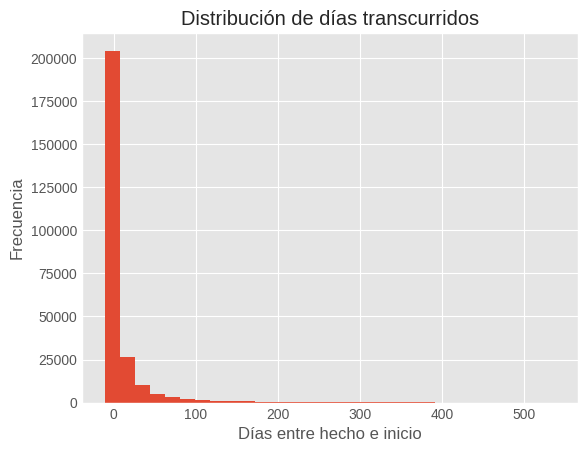

In [106]:
# Creamos una variable de días

Datos_OLD_ML['Dias'] = (
    pd.to_timedelta(
        pd.to_datetime(Datos_OLD_ML['fecha_inicio'] + '-' + Datos_OLD_ML['hora_inicio'],
                       format='%d/%m/%Y-%H:%M:%S') -
        pd.to_datetime(Datos_OLD_ML['fecha_hecho'] + '-' + Datos_OLD_ML['hora_hecho'],
                       format='%d/%m/%Y-%H:%M:%S')
    ).dt.total_seconds() / 3600  # convierte a horas
) / 24  # convierte a días

# Graficar histograma
Datos_OLD_ML['Dias'].hist(bins=30)
plt.xlabel('Días entre hecho e inicio')
plt.ylabel('Frecuencia')
plt.title('Distribución de días transcurridos')
plt.show()

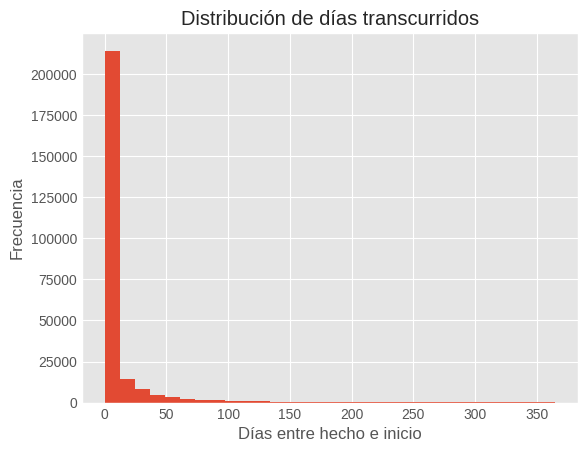

In [107]:
# Filtramos casos en los que no transcurrió más de 1 año entre la denuncia y el evento:

Datos_OLD_ML = Datos_OLD_ML[ ( Datos_OLD_ML['Dias'] >= 0 ) & ( Datos_OLD_ML['Dias'] <= 365 ) ]

Datos_OLD_ML['Dias'].hist( bins = 30 )
plt.xlabel('Días entre hecho e inicio')
plt.ylabel('Frecuencia')
plt.title('Distribución de días transcurridos')
plt.show()

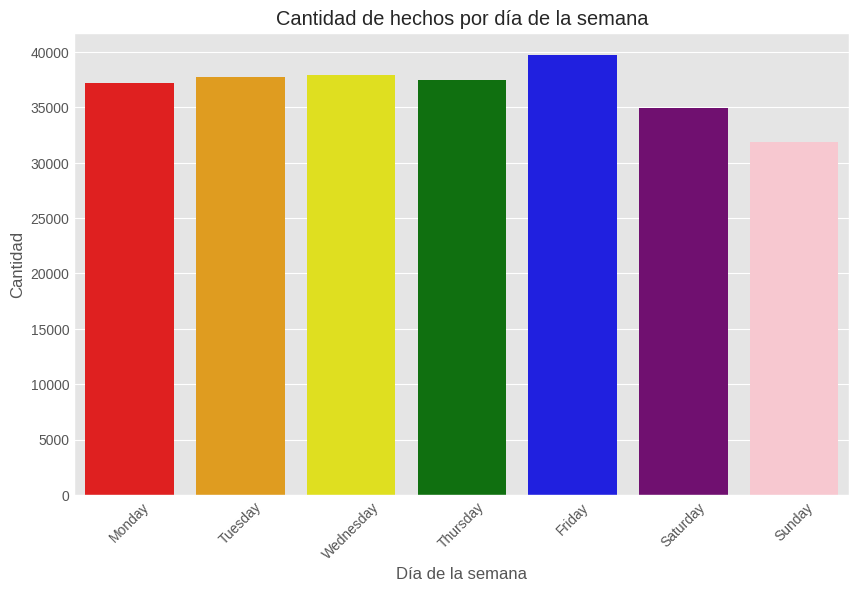

In [108]:
#
# Extraer el día de la semana

Datos_OLD_ML['fecha_hecho_dia'] = pd.to_datetime( Datos_OLD_ML['fecha_hecho'], dayfirst=True ).dt.day_name()

colores_dias = {
    'Monday': 'red',
    'Tuesday': 'orange',
    'Wednesday': 'yellow',
    'Thursday': 'green',
    'Friday': 'blue',
    'Saturday': 'purple',
    'Sunday': 'pink'
}

# Crear el gráfico
plt.figure(figsize=(10,6))
orden_dias = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

barras = sn.countplot(
    x="fecha_hecho_dia",
    data=Datos_OLD_ML,
    order=orden_dias,  # Para que salgan en orden correcto
    palette=[colores_dias[dia] for dia in orden_dias]
)

# Mostrar
plt.title('Cantidad de hechos por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.show()

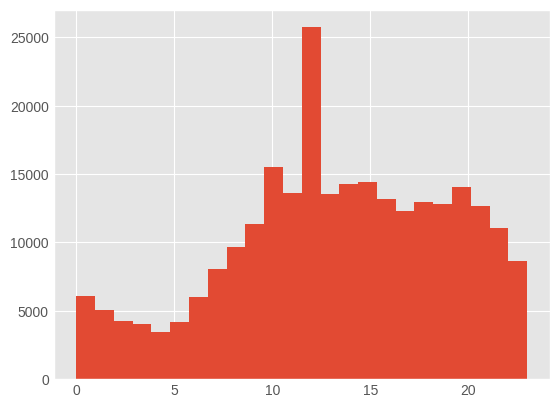

In [109]:
#
# Extraer hora

Datos_OLD_ML['hora_hecho_hora'] = pd.to_datetime( Datos_OLD_ML['hora_hecho'] ).dt.hour

Datos_OLD_ML['hora_hecho_hora'].hist( bins = 24 )

plt.show()

In [110]:
#

Datos_OLD_ML.sexo.value_counts()

,count
sexo,
Masculino,141094
Femenino,112472


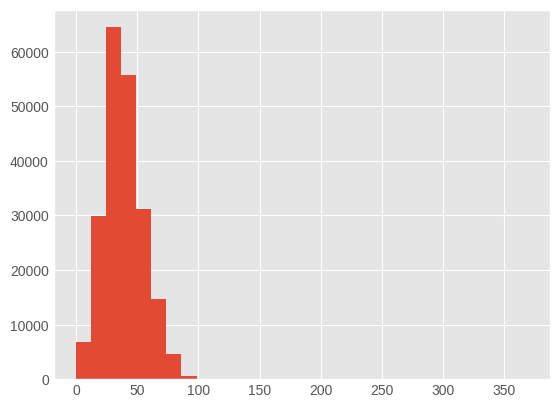

In [111]:
#

Datos_OLD_ML['edad'].hist( bins = 30 )

plt.show()

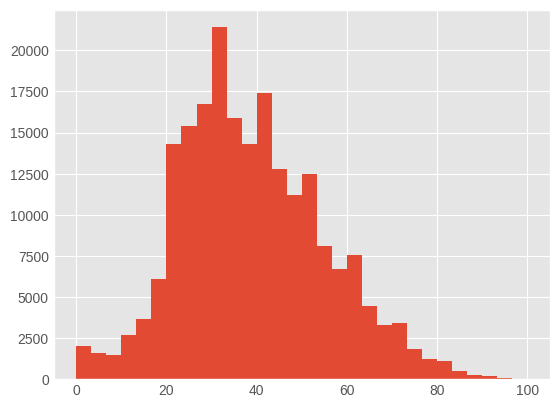

In [112]:
# Filtramos casos en los que no transcurrió más de 1 año entre la denuncia y el evento:

Datos_OLD_ML = Datos_OLD_ML[ ( Datos_OLD_ML['edad'] >= 0 ) & ( Datos_OLD_ML['edad'] <= 100 ) ]

Datos_OLD_ML['edad'].hist( bins = 30 )

plt.show()

In [113]:
#

Datos_OLD_ML.info()

<class 'pandas.core.frame.DataFrame'>
Index: 208078 entries, 3 to 369738
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Periodo           208078 non-null  object 
 1   fecha_inicio      208078 non-null  object 
 2   hora_inicio       208078 non-null  object 
 3   fecha_hecho       208078 non-null  object 
 4   hora_hecho        208078 non-null  object 
 5   categoria_delito  208078 non-null  object 
 6   sexo              207604 non-null  object 
 7   edad              208078 non-null  float64
 8   tipo_persona      207777 non-null  object 
 9   calidad_juridica  208078 non-null  object 
 10  latitud           200996 non-null  float64
 11  longitud          200996 non-null  float64
 12  personas          208078 non-null  object 
 13  Dias              208078 non-null  float64
 14  fecha_hecho_dia   208078 non-null  object 
 15  hora_hecho_hora   208078 non-null  int32  
dtypes: float64(4), int32(1), 

In [114]:
# Filtramos casos en los que no hay datos de longitud y latitud:

#Datos_OLD_ML[ ( Datos_OLD_ML['latitud'].isnull() ) | ( Datos_OLD_ML['longitud'].isnull() ) ]

Datos_OLD_ML = Datos_OLD_ML[ ( Datos_OLD_ML['latitud'].notnull() ) | ( Datos_OLD_ML['longitud'].notnull() ) ]

Datos_OLD_ML.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200996 entries, 3 to 369738
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Periodo           200996 non-null  object 
 1   fecha_inicio      200996 non-null  object 
 2   hora_inicio       200996 non-null  object 
 3   fecha_hecho       200996 non-null  object 
 4   hora_hecho        200996 non-null  object 
 5   categoria_delito  200996 non-null  object 
 6   sexo              200545 non-null  object 
 7   edad              200996 non-null  float64
 8   tipo_persona      200715 non-null  object 
 9   calidad_juridica  200996 non-null  object 
 10  latitud           200996 non-null  float64
 11  longitud          200996 non-null  float64
 12  personas          200996 non-null  object 
 13  Dias              200996 non-null  float64
 14  fecha_hecho_dia   200996 non-null  object 
 15  hora_hecho_hora   200996 non-null  int32  
dtypes: float64(4), int32(1), 

In [115]:
# Filtramos casos en los que no hay datos de tipo de persona:

Datos_OLD_ML = Datos_OLD_ML[ ( Datos_OLD_ML['tipo_persona'].notnull() )  ]

Datos_OLD_ML.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200715 entries, 3 to 369738
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Periodo           200715 non-null  object 
 1   fecha_inicio      200715 non-null  object 
 2   hora_inicio       200715 non-null  object 
 3   fecha_hecho       200715 non-null  object 
 4   hora_hecho        200715 non-null  object 
 5   categoria_delito  200715 non-null  object 
 6   sexo              200545 non-null  object 
 7   edad              200715 non-null  float64
 8   tipo_persona      200715 non-null  object 
 9   calidad_juridica  200715 non-null  object 
 10  latitud           200715 non-null  float64
 11  longitud          200715 non-null  float64
 12  personas          200715 non-null  object 
 13  Dias              200715 non-null  float64
 14  fecha_hecho_dia   200715 non-null  object 
 15  hora_hecho_hora   200715 non-null  int32  
dtypes: float64(4), int32(1), 

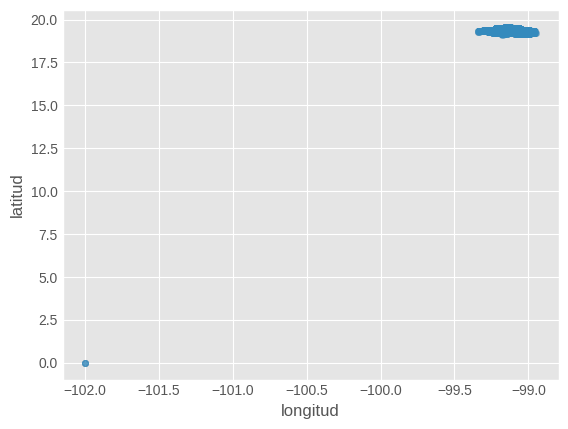

In [116]:
#

Datos_OLD_ML.plot(kind = 'scatter', x = 'longitud', y = 'latitud', alpha = 0.1)

plt.show()

#

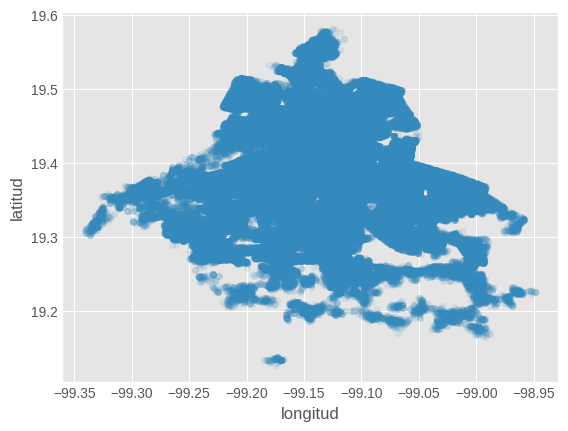

In [117]:
#
Datos_OLD_ML = Datos_OLD_ML[  Datos_OLD_ML['latitud'] > 17 ]

Datos_OLD_ML.plot(kind = 'scatter', x = 'longitud', y = 'latitud', alpha = 0.1)

plt.show()

In [118]:
#
Datos_OLD_ML = Datos_OLD_ML[ [ 'Periodo', 'categoria_delito', 'fecha_inicio', 'hora_inicio',
                       'fecha_hecho', 'hora_hecho', 'fecha_hecho_dia', 'hora_hecho_hora',
                       'sexo', 'edad', 'personas', 'Dias', 'latitud', 'longitud' ] ]

#

Datos_OLD.shape, Datos_OLD_ML.shape, 100 * Datos_OLD_ML.shape[0] / Datos_OLD.shape[0]

((369739, 23), (200700, 14), 54.28153373055047)

In [119]:
#

Datos_OLD_ML = pd.concat( [ Datos_OLD_ML, pd.get_dummies( Datos_OLD_ML['sexo'], dtype = float) ], axis = 1 )

Datos_OLD_ML = pd.concat( [ Datos_OLD_ML, pd.get_dummies( Datos_OLD_ML['personas'], dtype = float) ], axis = 1 )

Datos_OLD_ML = pd.concat( [ Datos_OLD_ML, pd.get_dummies( Datos_OLD_ML['fecha_hecho_dia'].astype(str), dtype = float) ], axis = 1 )

Datos_OLD_ML = pd.concat( [ Datos_OLD_ML, pd.get_dummies( Datos_OLD_ML['hora_hecho_hora'].astype(str), dtype = float) ], axis = 1 )

Datos_OLD_ML = Datos_OLD_ML[ [ 'Periodo', 'categoria_delito', 'fecha_hecho', 'hora_hecho',
                       'fecha_hecho_dia', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
                       'Friday', 'Saturday', 'Sunday', 'hora_hecho_hora', '0', '1', '2',
                       '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14',
                       '15', '16', '17', '18', '19', '20', '21', '22', '23', 'Dias',
                       'sexo', 'Femenino', 'Masculino', 'edad', 'personas', 'Victima',
                       'Victima_y_Otra', 'latitud', 'longitud',] ]

In [120]:
#

Datos_OLD_ML.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200700 entries, 3 to 369738
Data columns (total 47 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Periodo           200700 non-null  object 
 1   categoria_delito  200700 non-null  object 
 2   fecha_hecho       200700 non-null  object 
 3   hora_hecho        200700 non-null  object 
 4   fecha_hecho_dia   200700 non-null  object 
 5   Monday            200700 non-null  float64
 6   Tuesday           200700 non-null  float64
 7   Wednesday         200700 non-null  float64
 8   Thursday          200700 non-null  float64
 9   Friday            200700 non-null  float64
 10  Saturday          200700 non-null  float64
 11  Sunday            200700 non-null  float64
 12  hora_hecho_hora   200700 non-null  int32  
 13  0                 200700 non-null  float64
 14  1                 200700 non-null  float64
 15  2                 200700 non-null  float64
 16  3                 200700 

In [121]:
#

Datos_OLD_ML.describe()

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,hora_hecho_hora,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,Dias,Femenino,Masculino,edad,Victima,Victima_y_Otra,latitud,longitud
count,200700.000000,200700.000000,200700.000000,200700.000000,200700.000000,200700.000000,200700.000000,200700.000000,200700.00000,200700.000000,200700.000000,200700.000000,200700.000000,200700.000000,200700.00000,200700.000000,200700.000000,200700.000000,200700.000000,200700.000000,200700.000000,200700.000000,200700.000000,200700.000000,200700.000000,200700.000000,200700.000000,200700.000000,200700.000000,200700.000000,200700.000000,200700.000000,200700.000000,200700.000000,200700.000000,200700.000000,200700.000000,200700.000000,200700.000000,200700.000000
mean,0.143871,0.145187,0.145386,0.144136,0.153453,0.140394,0.127573,13.554400,0.01988,0.019387,0.016079,0.015077,0.013109,0.016672,0.02431,0.032357,0.039611,0.044285,0.055615,0.054758,0.074833,0.054529,0.058176,0.058211,0.054709,0.050548,0.053443,0.053029,0.058246,0.052297,0.045590,0.035247,7.335127,0.454783,0.544370,39.165212,0.180737,0.819263,19.384176,-99.134864
std,0.350960,0.352290,0.352491,0.351228,0.360424,0.347396,0.333615,5.876356,0.13959,0.137882,0.125779,0.121860,0.113742,0.128038,0.15401,0.176946,0.195045,0.205728,0.229178,0.227509,0.263122,0.227059,0.234077,0.234143,0.227411,0.219074,0.224916,0.224093,0.234209,0.222626,0.208596,0.184403,25.433199,0.497952,0.498029,15.872166,0.384801,0.384801,0.072173,0.061925
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.126646,-99.340720
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.169638,0.000000,0.000000,28.000000,0.000000,1.000000,19.333820,-99.175870
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.783953,0.000000,1.000000,37.000000,0.000000,1.000000,19.384870,-99.139550
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.171461,1.000000,1.000000,49.000000,0.000000,1.000000,19.438240,-99.094589
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,23.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,364.998611,1.000000,1.000000,100.000000,1.000000,1.000000,19.581110,-98.948320


In [122]:
# Seleccionamos solo los casos de interés para Dataset 01

Datos_OLD_ML = Datos_OLD_ML[ ( Datos_OLD_ML['categoria_delito'] == 'DELITO DE BAJO IMPACTO' ) | \
                             ( Datos_OLD_ML['categoria_delito'] == 'ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA' ) ]


In [123]:
# Variable categórica:
Datos_OLD_ML[ 'Delito' ] = 0

Datos_OLD_ML.loc[ Datos_OLD_ML['categoria_delito'] == 'ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA', 'Delito'] = 1

#
Datos_OLD_ML.shape


(169138, 48)

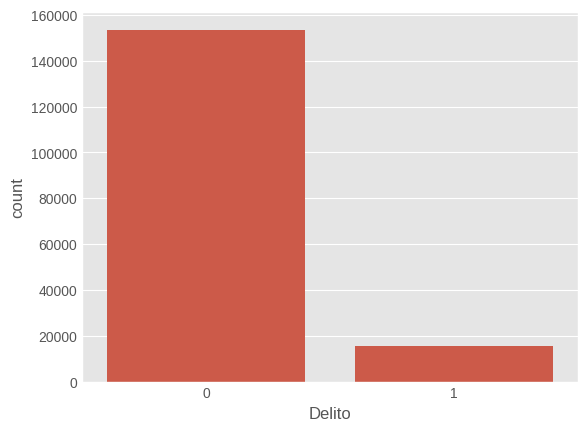

In [124]:
#

sn.countplot( x = 'Delito', data = Datos_OLD_ML)

plt.show()

In [125]:
#
Datos_OLD_ML.Delito.describe()

,Delito
count,169138.000000
mean,0.092138
std,0.289221
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [126]:
#

Datos_OLD_ML[ 'Constante' ] = 1

X_New = Datos_OLD_ML[[ 'Constante', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
                   '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14',
                   '15', '16', '17', '18', '19', '20', '21', '22', '23',
                   'Femenino', 'Victima', 'Dias', 'edad', 'latitud', 'longitud']]

Datos_OLD_ML[ 'Delito_Predict' ] = logreg.predict(X_New)

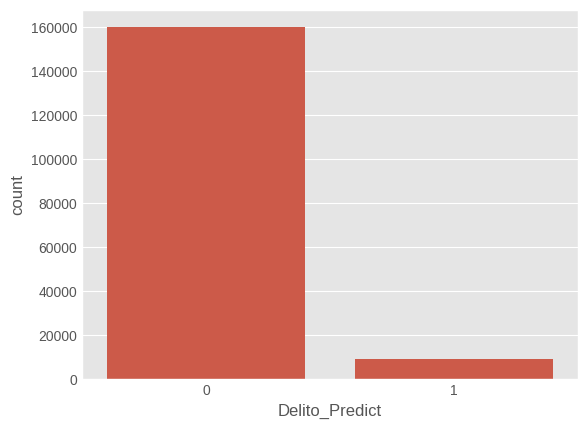

In [127]:
#

sn.countplot( x = 'Delito_Predict', data = Datos_OLD_ML)

plt.show()

In [128]:
#
Datos_OLD_ML.Delito_Predict.describe()

,Delito_Predict
count,169138.000000
mean,0.054015
std,0.226048
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000
